In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [5]:
df_train_val = pd.read_csv("train_val.csv")

In [10]:
for row in df_train_val.itertuples():
    if isinstance(row.date_time, str):
        df_train_val.at[row.Index, "date_time"] = row.date_time.split(" ")[0]

In [12]:
df_train_val["date_time"].astype(int)

0         20240601
1         20240601
2         20240601
3         20240601
4         20240601
            ...   
203995    20240824
203996    20240824
203997    20240824
203998    20240824
203999    20240824
Name: date_time, Length: 204000, dtype: int64

In [16]:
type(df_train_val["date_time"].iloc[0])

str

In [17]:
df_train = df_train_val[df_train_val["date_time"] <= "2024081800"]
df_val = df_train_val[df_train_val["date_time"] >= "2024081800"]


In [19]:
df_train["date_time"]

0         20240601
1         20240601
2         20240601
3         20240601
4         20240601
            ...   
203851    20240818
203852    20240818
203853    20240818
203854    20240818
203855    20240818
Name: date_time, Length: 189600, dtype: object

In [20]:
df_val["date_time"]

1896      20240819
1897      20240819
1898      20240819
1899      20240819
1900      20240819
            ...   
203995    20240824
203996    20240824
203997    20240824
203998    20240824
203999    20240824
Name: date_time, Length: 14400, dtype: object

In [22]:
X_train = df_train.drop(columns=["electricity_consumption"])
y_train = df_train["electricity_consumption"]
X_val = df_val.drop(columns=["electricity_consumption"])
y_val = df_val["electricity_consumption"]

In [24]:
# Check data types and identify string columns
print("Data types in training data:")
print(df_train.dtypes)
print("\nShape of training data:", df_train.shape)
print("\nFirst few rows of training data:")
print(df_train.head())

# Identify string/object columns
string_columns = df_train.select_dtypes(include=['object']).columns.tolist()
print(f"\nString/Object columns: {string_columns}")

# Check unique values in string columns
for col in string_columns:
    print(f"\nUnique values in '{col}' column:")
    print(df_train[col].value_counts().head(10))

Data types in training data:
Unnamed: 0                   int64
building_number              int64
date_time                   object
temperature                float64
precipitation              float64
wind_speed                 float64
humidity                   float64
sunshine_duration          float64
solar_radiation            float64
electricity_consumption    float64
building_type               object
total_floor_area           float64
air_conditioning_area      float64
dtype: object

Shape of training data: (189600, 13)

First few rows of training data:
   Unnamed: 0  building_number date_time  temperature  precipitation  \
0           0                1  20240601         18.3            0.0   
1           1                1  20240601         18.3            0.0   
2           2                1  20240601         18.1            0.0   
3           3                1  20240601         18.0            0.0   
4           4                1  20240601         17.8            0.0  

In [25]:
# String Data Categorization Methods

# Method 1: Label Encoding for ordinal categories
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Method 2: One-Hot Encoding for nominal categories  
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Method 3: Target Encoding (useful for high cardinality categorical features)
# This encodes categories based on their relationship with the target variable

def categorize_string_columns(df, target_col=None):
    """
    Suggest categorization methods for string columns based on their characteristics
    """
    string_cols = df.select_dtypes(include=['object']).columns.tolist()
    categorization_suggestions = {}
    
    for col in string_cols:
        unique_count = df[col].nunique()
        total_count = len(df)
        cardinality_ratio = unique_count / total_count
        
        print(f"\nColumn: {col}")
        print(f"Unique values: {unique_count}")
        print(f"Cardinality ratio: {cardinality_ratio:.4f}")
        print(f"Sample values: {df[col].unique()[:5]}")
        
        # Suggest encoding method based on characteristics
        if unique_count <= 2:
            suggestion = "Binary/Label Encoding"
        elif unique_count <= 10 and cardinality_ratio < 0.1:
            suggestion = "One-Hot Encoding"
        elif unique_count <= 50 and cardinality_ratio < 0.3:
            suggestion = "Label Encoding or Target Encoding"
        else:
            suggestion = "Target Encoding or Feature Hashing"
            
        categorization_suggestions[col] = suggestion
        print(f"Suggested method: {suggestion}")
    
    return categorization_suggestions

# Apply to your dataset
suggestions = categorize_string_columns(df_train)


Column: date_time
Unique values: 79
Cardinality ratio: 0.0004
Sample values: ['20240601' '20240602' '20240603' '20240604' '20240605']
Suggested method: Target Encoding or Feature Hashing

Column: building_type
Unique values: 10
Cardinality ratio: 0.0001
Sample values: ['Hotel' 'Common' 'Hospital' 'School' 'Other']
Suggested method: One-Hot Encoding


In [26]:
# Implementation of String Data Categorization Methods

def apply_categorization(X_train, X_val, column_name, method='one_hot', target_y=None):
    """
    Apply categorization method to string columns
    
    Parameters:
    - X_train, X_val: DataFrames to transform
    - column_name: Name of the column to categorize
    - method: 'one_hot', 'label', 'target', 'frequency'
    - target_y: Target variable for target encoding
    """
    X_train_copy = X_train.copy()
    X_val_copy = X_val.copy()
    
    if method == 'one_hot':
        # One-Hot Encoding
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        
        # Fit on training data
        encoded_train = encoder.fit_transform(X_train_copy[[column_name]])
        encoded_val = encoder.transform(X_val_copy[[column_name]])
        
        # Get feature names
        feature_names = [f"{column_name}_{cat}" for cat in encoder.categories_[0]]
        
        # Create DataFrames
        encoded_train_df = pd.DataFrame(encoded_train, columns=feature_names, index=X_train_copy.index)
        encoded_val_df = pd.DataFrame(encoded_val, columns=feature_names, index=X_val_copy.index)
        
        # Drop original column and add encoded columns
        X_train_copy = X_train_copy.drop(columns=[column_name])
        X_val_copy = X_val_copy.drop(columns=[column_name])
        X_train_copy = pd.concat([X_train_copy, encoded_train_df], axis=1)
        X_val_copy = pd.concat([X_val_copy, encoded_val_df], axis=1)
        
    elif method == 'label':
        # Label Encoding
        encoder = LabelEncoder()
        X_train_copy[column_name] = encoder.fit_transform(X_train_copy[column_name])
        # Handle unseen categories in validation set
        X_val_copy[column_name] = X_val_copy[column_name].map(
            dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
        ).fillna(-1)  # Assign -1 to unseen categories
        
    elif method == 'target':
        # Target Encoding (mean encoding)
        if target_y is None:
            raise ValueError("Target variable required for target encoding")
        
        # Calculate mean target value for each category
        target_means = pd.DataFrame({'category': X_train_copy[column_name], 'target': target_y}).groupby('category')['target'].mean()
        
        # Apply encoding
        X_train_copy[column_name] = X_train_copy[column_name].map(target_means)
        X_val_copy[column_name] = X_val_copy[column_name].map(target_means).fillna(target_means.mean())
        
    elif method == 'frequency':
        # Frequency Encoding
        freq_encoding = X_train_copy[column_name].value_counts().to_dict()
        X_train_copy[column_name] = X_train_copy[column_name].map(freq_encoding)
        X_val_copy[column_name] = X_val_copy[column_name].map(freq_encoding).fillna(0)
    
    return X_train_copy, X_val_copy

# Example implementations for your data:

# 1. One-Hot Encoding for building_type (low cardinality)
print("=== One-Hot Encoding for building_type ===")
X_train_oh, X_val_oh = apply_categorization(X_train, X_val, 'building_type', 'one_hot')
print(f"Original shape: {X_train.shape}")
print(f"After one-hot encoding: {X_train_oh.shape}")
print(f"New columns: {[col for col in X_train_oh.columns if 'building_type' in col]}")

# 2. Target Encoding for date_time (high cardinality)
print("\n=== Target Encoding for date_time ===")
X_train_te, X_val_te = apply_categorization(X_train, X_val, 'date_time', 'target', target_y=y_train)
print(f"Sample encoded values for date_time: {X_train_te['date_time'].head()}")

# 3. Label Encoding for building_type (alternative approach)
print("\n=== Label Encoding for building_type ===")
X_train_le, X_val_le = apply_categorization(X_train, X_val, 'building_type', 'label')
print(f"Sample encoded values for building_type: {X_train_le['building_type'].head()}")

# 4. Frequency Encoding
print("\n=== Frequency Encoding for building_type ===")
X_train_fe, X_val_fe = apply_categorization(X_train, X_val, 'building_type', 'frequency')
print(f"Sample frequency encoded values: {X_train_fe['building_type'].head()}")

=== One-Hot Encoding for building_type ===
Original shape: (189600, 12)
After one-hot encoding: (189600, 21)
New columns: ['building_type_Apartment', 'building_type_Common', 'building_type_Department Store', 'building_type_Hospital', 'building_type_Hotel', 'building_type_IDC', 'building_type_Other', 'building_type_Public', 'building_type_Research Institute', 'building_type_School']

=== Target Encoding for date_time ===
Sample encoded values for date_time: 0    2670.273183
1    2670.273183
2    2670.273183
3    2670.273183
4    2670.273183
Name: date_time, dtype: float64

=== Label Encoding for building_type ===
Sample encoded values for building_type: 0    4
1    4
2    4
3    4
4    4
Name: building_type, dtype: int64

=== Frequency Encoding for building_type ===
Sample frequency encoded values: 0    18960
1    18960
2    18960
3    18960
4    18960
Name: building_type, dtype: int64


In [28]:
# Apply optimal encoding for both string columns
# Use One-Hot for building_type and Target encoding for date_time

# First, apply one-hot encoding to building_type
X_train_encoded, X_val_encoded = apply_categorization(X_train, X_val, 'building_type', 'one_hot')

# Then apply target encoding to date_time
X_train_final, X_val_final = apply_categorization(X_train_encoded, X_val_encoded, 'date_time', 'target', target_y=y_train)

print(f"Final encoded data shape:")
print(f"Training: {X_train_final.shape}")
print(f"Validation: {X_val_final.shape}")
print(f"Data types after encoding:")
print(X_train_final.dtypes.value_counts())

# XGBoost model to regress electricity consumption
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
model.fit(X_train_final, y_train)

# Predictions
y_pred_train = model.predict(X_train_final)
y_pred_val = model.predict(X_val_final)

Final encoded data shape:
Training: (189600, 21)
Validation: (14400, 21)
Data types after encoding:
float64    19
int64       2
Name: count, dtype: int64


In [29]:
# Evaluate model performance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Calculate metrics
train_mse = mean_squared_error(y_train, y_pred_train)
val_mse = mean_squared_error(y_val, y_pred_val)
train_rmse = np.sqrt(train_mse)
val_rmse = np.sqrt(val_mse)
train_r2 = r2_score(y_train, y_pred_train)
val_r2 = r2_score(y_val, y_pred_val)
train_mae = mean_absolute_error(y_train, y_pred_train)
val_mae = mean_absolute_error(y_val, y_pred_val)

print("=== Model Performance Metrics ===")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Validation R²: {val_r2:.4f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

# Check for overfitting
print(f"\n=== Overfitting Check ===")
print(f"RMSE difference (Val - Train): {val_rmse - train_rmse:.2f}")
print(f"R² difference (Train - Val): {train_r2 - val_r2:.4f}")

if val_rmse - train_rmse > train_rmse * 0.2:  # 20% threshold
    print("⚠️  Potential overfitting detected")
else:
    print("✅ Model generalization looks good")

=== Model Performance Metrics ===
Training RMSE: 591.87
Validation RMSE: 933.30
Training R²: 0.9740
Validation R²: 0.9425
Training MAE: 366.68
Validation MAE: 573.80

=== Overfitting Check ===
RMSE difference (Val - Train): 341.44
R² difference (Train - Val): 0.0316
⚠️  Potential overfitting detected


In [30]:
# Install and import SHAP for Shapley values analysis
try:
    import shap
except ImportError:
    print("Installing SHAP...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap

print("SHAP version:", shap.__version__)

SHAP version: 0.48.0


In [31]:
# SHAP Analysis for Model Interpretability

# Create SHAP explainer for XGBoost
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for a sample of validation data (for performance)
# Using a sample to avoid memory issues with large datasets
sample_size = min(1000, len(X_val_final))
X_val_sample = X_val_final.sample(n=sample_size, random_state=42)
shap_values = explainer.shap_values(X_val_sample)

print(f"SHAP values calculated for {sample_size} validation samples")
print(f"SHAP values shape: {shap_values.shape}")
print(f"Feature names: {list(X_val_final.columns)}")

# Feature importance based on mean absolute SHAP values
feature_importance = pd.DataFrame({
    'feature': X_val_final.columns,
    'importance': np.mean(np.abs(shap_values), axis=0)
}).sort_values('importance', ascending=False)

print("\n=== Top 10 Most Important Features (by SHAP) ===")
for i, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

SHAP values calculated for 1000 validation samples
SHAP values shape: (1000, 21)
Feature names: ['Unnamed: 0', 'building_number', 'date_time', 'temperature', 'precipitation', 'wind_speed', 'humidity', 'sunshine_duration', 'solar_radiation', 'total_floor_area', 'air_conditioning_area', 'building_type_Apartment', 'building_type_Common', 'building_type_Department Store', 'building_type_Hospital', 'building_type_Hotel', 'building_type_IDC', 'building_type_Other', 'building_type_Public', 'building_type_Research Institute', 'building_type_School']

=== Top 10 Most Important Features (by SHAP) ===
building_type_IDC: 1149.4578
total_floor_area: 905.4901
Unnamed: 0: 571.1636
air_conditioning_area: 450.7180
solar_radiation: 299.2644
building_type_Apartment: 263.8072
building_number: 242.8129
temperature: 159.1678
building_type_School: 100.6642
building_type_Department Store: 79.8352


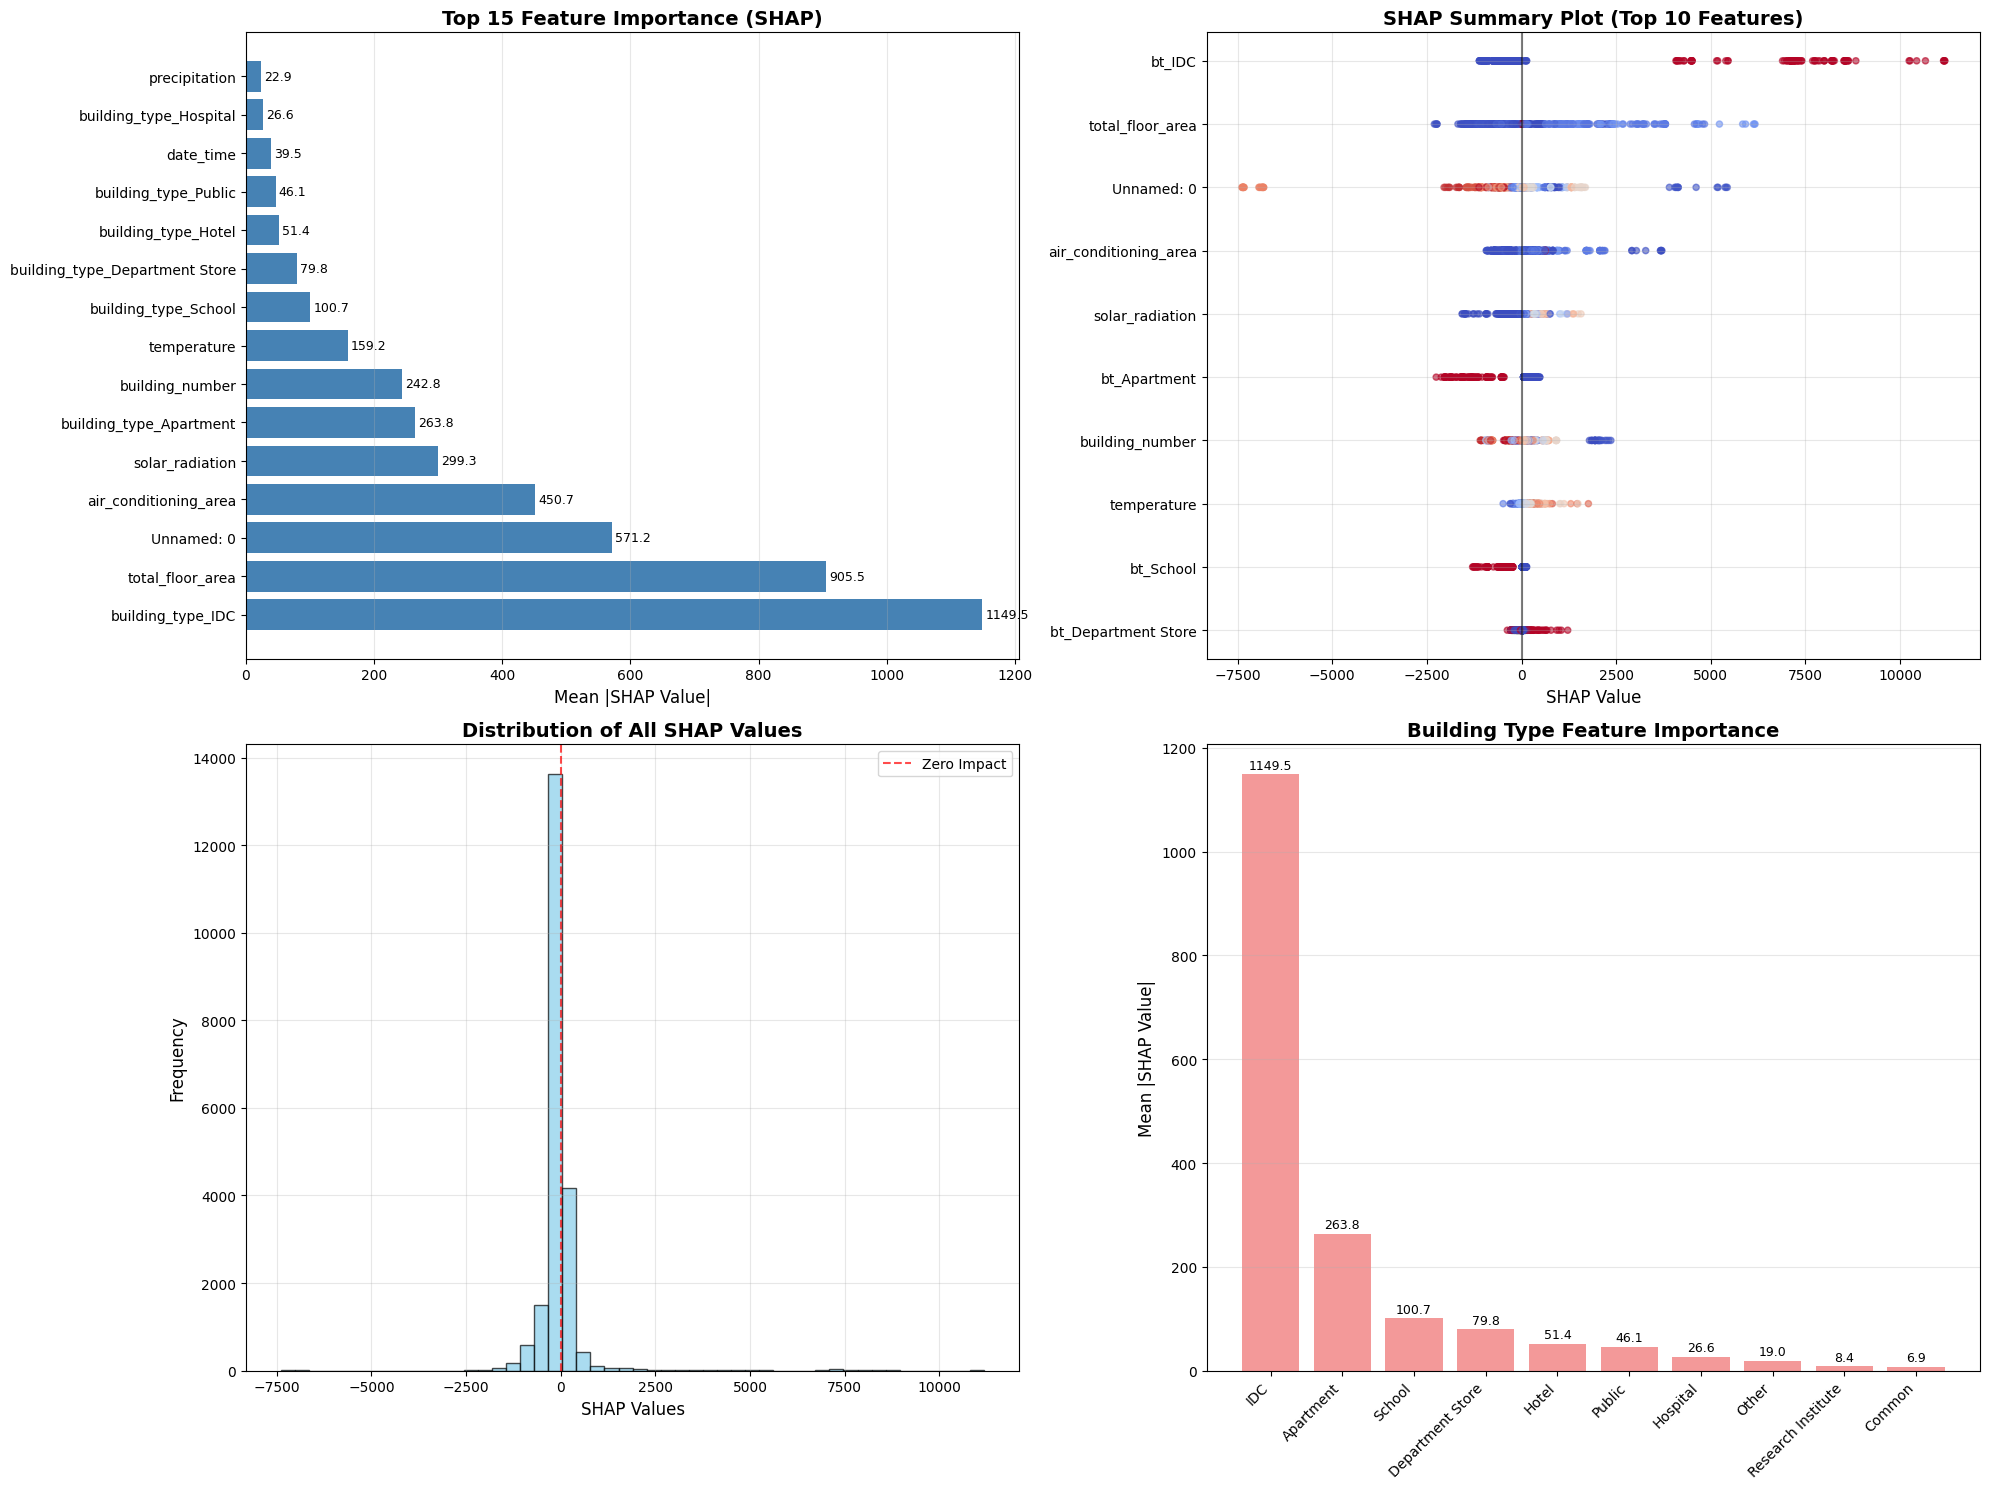


🔍 SHAP ANALYSIS INSIGHTS

📊 MODEL INTERPRETABILITY SUMMARY:
• Most impactful feature: building_type_IDC (SHAP: 1149.5)
• Least impactful feature: building_type_Common (SHAP: 6.9)

🏢 BUILDING TYPE INSIGHTS:
• Most important building type: IDC (SHAP: 1149.5)

🌡️ ENVIRONMENTAL FACTORS:
• temperature: Rank #4, SHAP: 159.2
• humidity: Rank #7, SHAP: 14.4
• solar_radiation: Rank #9, SHAP: 299.3
• wind_speed: Rank #6, SHAP: 13.3
• precipitation: Rank #5, SHAP: 22.9

🏗️ BUILDING CHARACTERISTICS:
• total_floor_area: Rank #10, SHAP: 905.5
• air_conditioning_area: Rank #11, SHAP: 450.7
• building_number: Rank #2, SHAP: 242.8


In [32]:
# SHAP Visualizations

# Set up the plot style
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# 1. Feature Importance Bar Plot
ax1 = axes[0, 0]
top_features = feature_importance.head(15)
bars = ax1.barh(range(len(top_features)), top_features['importance'], color='steelblue')
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['feature'], fontsize=10)
ax1.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax1.set_title('Top 15 Feature Importance (SHAP)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width + 5, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}', ha='left', va='center', fontsize=9)

# 2. SHAP Summary Plot (using matplotlib since we can't use shap.plots directly)
ax2 = axes[0, 1]
# Create a summary plot manually
top_10_features = feature_importance.head(10)['feature'].tolist()
top_10_indices = [list(X_val_final.columns).index(feat) for feat in top_10_features]

shap_top10 = shap_values[:, top_10_indices]
feature_values_top10 = X_val_sample[top_10_features].values

# Create scatter plot for each feature
colors = plt.cm.viridis(np.linspace(0, 1, len(top_10_features)))
for i, (feat_idx, feat_name) in enumerate(zip(range(len(top_10_features)), top_10_features)):
    y_positions = np.full(len(shap_top10[:, feat_idx]), len(top_10_features) - i - 1)
    scatter = ax2.scatter(shap_top10[:, feat_idx], y_positions, 
                         c=feature_values_top10[:, feat_idx], 
                         cmap='coolwarm', alpha=0.6, s=20)

ax2.set_yticks(range(len(top_10_features)))
ax2.set_yticklabels([f.replace('building_type_', 'bt_') for f in top_10_features[::-1]], fontsize=10)
ax2.set_xlabel('SHAP Value', fontsize=12)
ax2.set_title('SHAP Summary Plot (Top 10 Features)', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)

# 3. SHAP values distribution
ax3 = axes[1, 0]
ax3.hist(shap_values.flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax3.set_xlabel('SHAP Values', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution of All SHAP Values', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)
ax3.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero Impact')
ax3.legend()

# 4. Feature contribution comparison (Building types)
ax4 = axes[1, 1]
building_features = [col for col in feature_importance['feature'] if 'building_type_' in col]
building_importance = feature_importance[feature_importance['feature'].isin(building_features)]

bars = ax4.bar(range(len(building_importance)), building_importance['importance'], 
               color='lightcoral', alpha=0.8)
ax4.set_xticks(range(len(building_importance)))
ax4.set_xticklabels([f.replace('building_type_', '') for f in building_importance['feature']], 
                    rotation=45, ha='right', fontsize=10)
ax4.set_ylabel('Mean |SHAP Value|', fontsize=12)
ax4.set_title('Building Type Feature Importance', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2, height + 5, 
             f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print detailed insights
print("\n" + "="*60)
print("🔍 SHAP ANALYSIS INSIGHTS")
print("="*60)

print(f"\n📊 MODEL INTERPRETABILITY SUMMARY:")
print(f"• Most impactful feature: {feature_importance.iloc[0]['feature']} (SHAP: {feature_importance.iloc[0]['importance']:.1f})")
print(f"• Least impactful feature: {feature_importance.iloc[-1]['feature']} (SHAP: {feature_importance.iloc[-1]['importance']:.1f})")

print(f"\n🏢 BUILDING TYPE INSIGHTS:")
bt_features = feature_importance[feature_importance['feature'].str.contains('building_type_')]
if len(bt_features) > 0:
    most_important_bt = bt_features.iloc[0]
    print(f"• Most important building type: {most_important_bt['feature'].replace('building_type_', '')} (SHAP: {most_important_bt['importance']:.1f})")

print(f"\n🌡️ ENVIRONMENTAL FACTORS:")
env_features = ['temperature', 'humidity', 'solar_radiation', 'wind_speed', 'precipitation']
for feat in env_features:
    if feat in feature_importance['feature'].values:
        importance = feature_importance[feature_importance['feature'] == feat]['importance'].iloc[0]
        rank = feature_importance[feature_importance['feature'] == feat].index[0] + 1
        print(f"• {feat}: Rank #{rank}, SHAP: {importance:.1f}")

print(f"\n🏗️ BUILDING CHARACTERISTICS:")
building_chars = ['total_floor_area', 'air_conditioning_area', 'building_number']
for feat in building_chars:
    if feat in feature_importance['feature'].values:
        importance = feature_importance[feature_importance['feature'] == feat]['importance'].iloc[0]
        rank = feature_importance[feature_importance['feature'] == feat].index[0] + 1
        print(f"• {feat}: Rank #{rank}, SHAP: {importance:.1f}")

In [33]:
# Remove Unnamed: 0 column and create building-type-specific models

# First, remove the Unnamed: 0 column from original data
print("Original columns:", list(X_train.columns))
if 'Unnamed: 0' in X_train.columns:
    X_train_clean = X_train.drop(columns=['Unnamed: 0'])
    X_val_clean = X_val.drop(columns=['Unnamed: 0'])
    print("Removed 'Unnamed: 0' column")
else:
    X_train_clean = X_train.copy()
    X_val_clean = X_val.copy()
    print("'Unnamed: 0' column not found")

print("Cleaned columns:", list(X_train_clean.columns))

# Get unique building types
building_types = X_train_clean['building_type'].unique()
print(f"\nBuilding types found: {building_types}")
print(f"Number of building types: {len(building_types)}")

# Check data distribution across building types
print("\n=== Data Distribution by Building Type ===")
train_dist = X_train_clean['building_type'].value_counts()
val_dist = X_val_clean['building_type'].value_counts()
print("Training data distribution:")
print(train_dist)
print("\nValidation data distribution:")
print(val_dist)

Original columns: ['Unnamed: 0', 'building_number', 'date_time', 'temperature', 'precipitation', 'wind_speed', 'humidity', 'sunshine_duration', 'solar_radiation', 'building_type', 'total_floor_area', 'air_conditioning_area']
Removed 'Unnamed: 0' column
Cleaned columns: ['building_number', 'date_time', 'temperature', 'precipitation', 'wind_speed', 'humidity', 'sunshine_duration', 'solar_radiation', 'building_type', 'total_floor_area', 'air_conditioning_area']

Building types found: ['Hotel' 'Common' 'Hospital' 'School' 'Other' 'Apartment'
 'Research Institute' 'Department Store' 'IDC' 'Public']
Number of building types: 10

=== Data Distribution by Building Type ===
Training data distribution:
building_type
Department Store      30336
Hotel                 18960
Common                18960
School                18960
Other                 18960
Hospital              17064
Apartment             17064
Research Institute    17064
IDC                   17064
Public                15168
Name

In [34]:
# Create separate models for each building type

# Dictionary to store models and results
building_models = {}
building_results = {}

print("=" * 80)
print("🏢 TRAINING BUILDING-TYPE-SPECIFIC MODELS")
print("=" * 80)

for building_type in building_types:
    print(f"\n📊 Processing {building_type} buildings...")
    
    # Filter data for this building type
    train_mask = X_train_clean['building_type'] == building_type
    val_mask = X_val_clean['building_type'] == building_type
    
    X_train_bt = X_train_clean[train_mask].copy()
    y_train_bt = y_train[train_mask].copy()
    X_val_bt = X_val_clean[val_mask].copy()
    y_val_bt = y_val[val_mask].copy()
    
    print(f"   Training samples: {len(X_train_bt)}")
    print(f"   Validation samples: {len(X_val_bt)}")
    
    # Remove building_type column since it's constant for each model
    X_train_bt = X_train_bt.drop(columns=['building_type'])
    X_val_bt = X_val_bt.drop(columns=['building_type'])
    
    # Apply target encoding to date_time for this building type
    X_train_encoded, X_val_encoded = apply_categorization(
        X_train_bt, X_val_bt, 'date_time', 'target', target_y=y_train_bt
    )
    
    # Train XGBoost model for this building type
    model_bt = XGBRegressor(
        objective='reg:squarederror', 
        n_estimators=100, 
        learning_rate=0.1, 
        max_depth=6,
        random_state=42
    )
    
    model_bt.fit(X_train_encoded, y_train_bt)
    
    # Make predictions
    y_pred_train_bt = model_bt.predict(X_train_encoded)
    y_pred_val_bt = model_bt.predict(X_val_encoded)
    
    # Calculate metrics
    train_rmse_bt = np.sqrt(mean_squared_error(y_train_bt, y_pred_train_bt))
    val_rmse_bt = np.sqrt(mean_squared_error(y_val_bt, y_pred_val_bt))
    train_r2_bt = r2_score(y_train_bt, y_pred_train_bt)
    val_r2_bt = r2_score(y_val_bt, y_pred_val_bt)
    train_mae_bt = mean_absolute_error(y_train_bt, y_pred_train_bt)
    val_mae_bt = mean_absolute_error(y_val_bt, y_pred_val_bt)
    
    # Store results
    building_models[building_type] = {
        'model': model_bt,
        'X_train': X_train_encoded,
        'X_val': X_val_encoded,
        'y_train': y_train_bt,
        'y_val': y_val_bt,
        'y_pred_train': y_pred_train_bt,
        'y_pred_val': y_pred_val_bt
    }
    
    building_results[building_type] = {
        'train_samples': len(X_train_bt),
        'val_samples': len(X_val_bt),
        'train_rmse': train_rmse_bt,
        'val_rmse': val_rmse_bt,
        'train_r2': train_r2_bt,
        'val_r2': val_r2_bt,
        'train_mae': train_mae_bt,
        'val_mae': val_mae_bt,
        'overfitting_ratio': (val_rmse_bt - train_rmse_bt) / train_rmse_bt
    }
    
    print(f"   ✅ Model trained - Val RMSE: {val_rmse_bt:.2f}, Val R²: {val_r2_bt:.4f}")

print(f"\n🎯 All {len(building_types)} building-type-specific models trained successfully!")

🏢 TRAINING BUILDING-TYPE-SPECIFIC MODELS

📊 Processing Hotel buildings...
   Training samples: 18960
   Validation samples: 1440
   ✅ Model trained - Val RMSE: 1082.50, Val R²: 0.8540

📊 Processing Common buildings...
   Training samples: 18960
   Validation samples: 1440
   ✅ Model trained - Val RMSE: 480.80, Val R²: 0.8956

📊 Processing Hospital buildings...
   Training samples: 17064
   Validation samples: 1296
   ✅ Model trained - Val RMSE: 1566.39, Val R²: 0.9237

📊 Processing School buildings...
   Training samples: 18960
   Validation samples: 1440
   ✅ Model trained - Val RMSE: 711.53, Val R²: 0.9414

📊 Processing Other buildings...
   Training samples: 18960
   Validation samples: 1440
   ✅ Model trained - Val RMSE: 1341.51, Val R²: 0.7242

📊 Processing Apartment buildings...
   Training samples: 17064
   Validation samples: 1296
   ✅ Model trained - Val RMSE: 386.61, Val R²: 0.8516

📊 Processing Research Institute buildings...
   Training samples: 17064
   Validation samples:

📊 BUILDING-TYPE-SPECIFIC MODEL PERFORMANCE COMPARISON

🏆 RANKING BY VALIDATION R² SCORE:
--------------------------------------------------
 1. 🟢 IDC                | R²: 0.9868 | RMSE:   554.07 | ⚠️
 2. 🟢 School             | R²: 0.9414 | RMSE:   711.53 | ⚠️
 3. 🟢 Hospital           | R²: 0.9237 | RMSE:  1566.39 | ⚠️
 4. 🟢 Common             | R²: 0.8956 | RMSE:   480.80 | ⚠️
 5. 🟢 Department Store   | R²: 0.8867 | RMSE:  1111.66 | ⚠️
 6. 🟢 Hotel              | R²: 0.8540 | RMSE:  1082.50 | ⚠️
 7. 🟢 Apartment          | R²: 0.8516 | RMSE:   386.61 | ⚠️
 8. 🟡 Other              | R²: 0.7242 | RMSE:  1341.51 | ⚠️
 9. 🟡 Public             | R²: 0.6092 | RMSE:   559.54 | ⚠️
10. 🔴 Research Institute | R²: 0.4402 | RMSE:   714.79 | ⚠️

📈 DETAILED PERFORMANCE METRICS:
------------------------------------------------------------------------------------------------------------------------
Building Type      Samples  Train R²  Val R²    Train RMSE  Val RMSE   Overfit % 
------------------------

/var/folders/z9/hg3hgmdn7fq2v90_5bg9xx0c0000gn/T/ipykernel_60814/3946664038.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(buildings, rotation=45, ha='right')
/var/folders/z9/hg3hgmdn7fq2v90_5bg9xx0c0000gn/T/ipykernel_60814/3946664038.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(buildings, rotation=45, ha='right')
/var/folders/z9/hg3hgmdn7fq2v90_5bg9xx0c0000gn/T/ipykernel_60814/3946664038.py:161: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/z9/hg3hgmdn7fq2v90_5bg9xx0c0000gn/T/ipykernel_60814/3946664038.py:161: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/z9/hg3hgmdn7fq2v90_5bg9xx0c0000gn/T/ipykernel_60814/3946664038.py:161: UserWarni

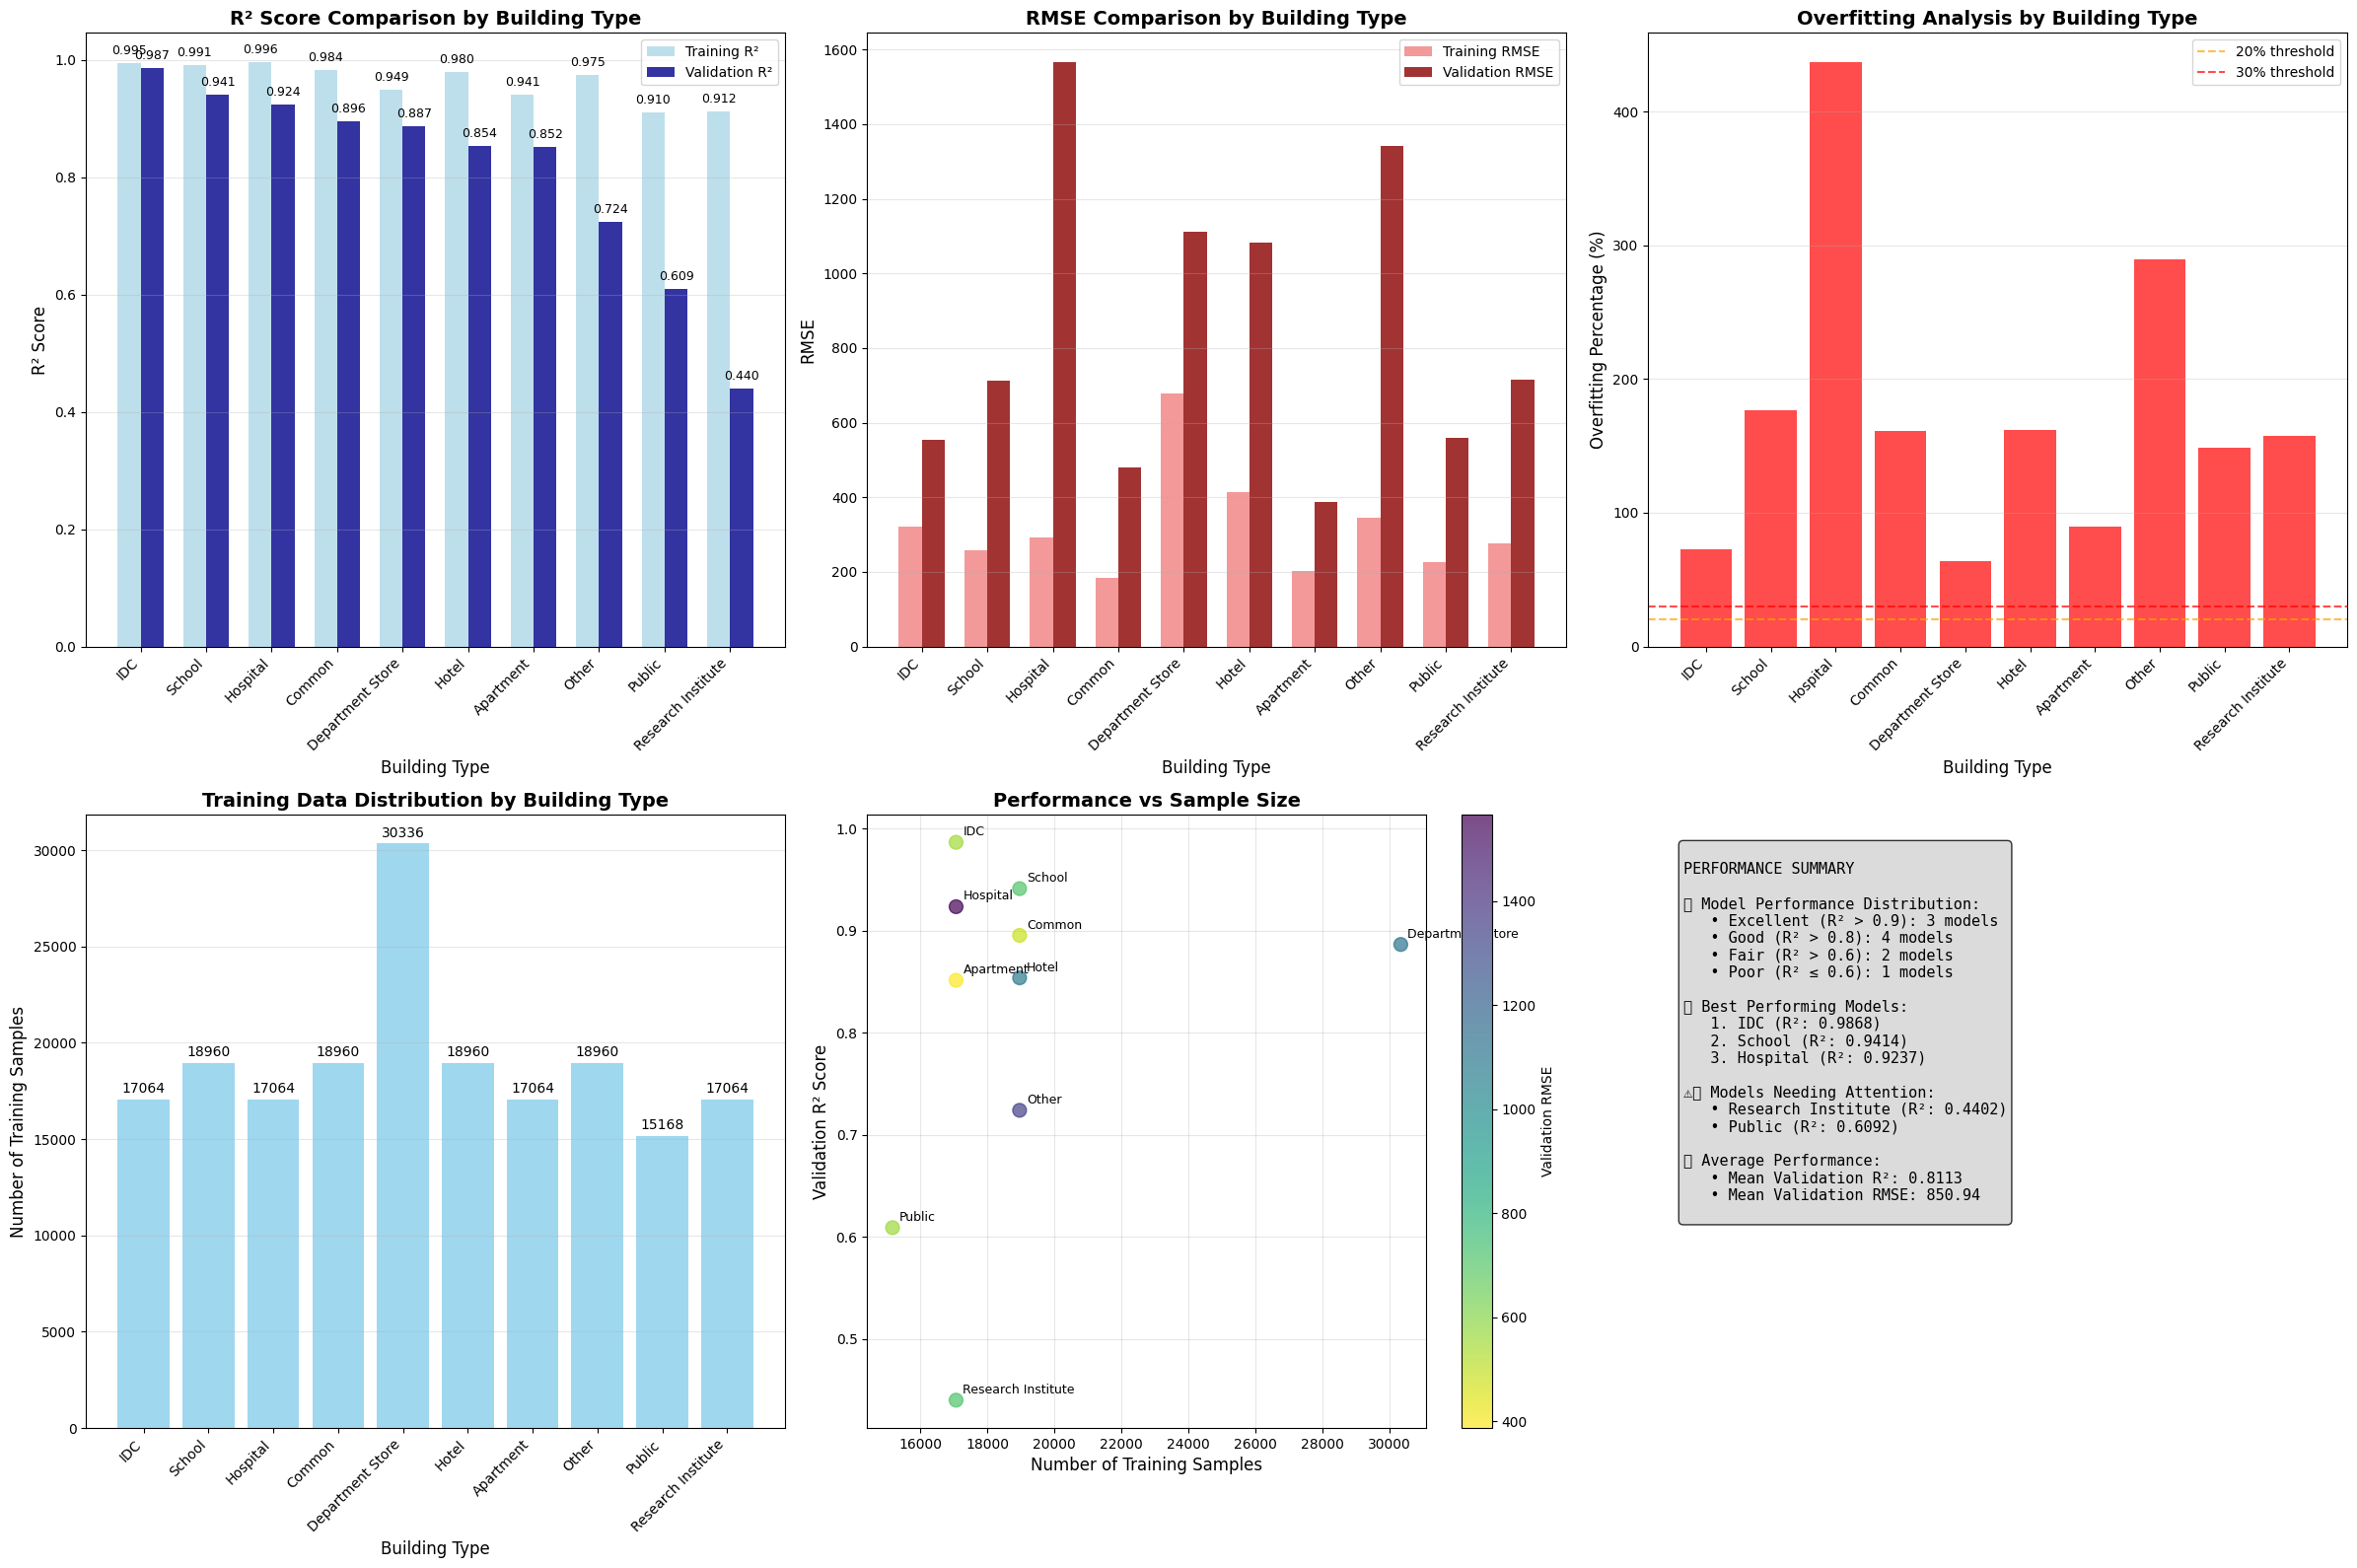


💡 KEY INSIGHTS:
• Best performing model: IDC (R² = 0.9868)
• Most challenging building type: Research Institute (R² = 0.4402)
• Average improvement potential: 0.1520
• Models with minimal overfitting: 0 out of 10


In [36]:
# Comprehensive Results Analysis and Visualization

# Create results DataFrame
results_df = pd.DataFrame(building_results).T
results_df = results_df.round(4)

print("=" * 100)
print("📊 BUILDING-TYPE-SPECIFIC MODEL PERFORMANCE COMPARISON")
print("=" * 100)

# Sort by validation R² score (best performance first)
results_sorted = results_df.sort_values('val_r2', ascending=False)

print("\n🏆 RANKING BY VALIDATION R² SCORE:")
print("-" * 50)
for i, (building_type, row) in enumerate(results_sorted.iterrows(), 1):
    status = "🟢" if row['val_r2'] > 0.8 else "🟡" if row['val_r2'] > 0.6 else "🔴"
    overfitting_status = "⚠️" if row['overfitting_ratio'] > 0.3 else "✅"
    print(f"{i:2d}. {status} {building_type:18s} | R²: {row['val_r2']:.4f} | RMSE: {row['val_rmse']:8.2f} | {overfitting_status}")

print(f"\n📈 DETAILED PERFORMANCE METRICS:")
print("-" * 120)
print(f"{'Building Type':<18} {'Samples':<8} {'Train R²':<9} {'Val R²':<9} {'Train RMSE':<11} {'Val RMSE':<10} {'Overfit %':<10}")
print("-" * 120)

for building_type, row in results_sorted.iterrows():
    print(f"{building_type:<18} {int(row['train_samples']):<8d} {row['train_r2']:<9.4f} {row['val_r2']:<9.4f} "
          f"{row['train_rmse']:<11.2f} {row['val_rmse']:<10.2f} {row['overfitting_ratio']*100:<10.1f}")

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

# 1. R² Score Comparison
ax1 = axes[0, 0]
buildings = results_sorted.index
train_r2 = results_sorted['train_r2']
val_r2 = results_sorted['val_r2']

x = np.arange(len(buildings))
width = 0.35

bars1 = ax1.bar(x - width/2, train_r2, width, label='Training R²', alpha=0.8, color='lightblue')
bars2 = ax1.bar(x + width/2, val_r2, width, label='Validation R²', alpha=0.8, color='darkblue')

ax1.set_xlabel('Building Type', fontsize=12)
ax1.set_ylabel('R² Score', fontsize=12)
ax1.set_title('R² Score Comparison by Building Type', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(buildings, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. RMSE Comparison
ax2 = axes[0, 1]
train_rmse = results_sorted['train_rmse']
val_rmse = results_sorted['val_rmse']

bars3 = ax2.bar(x - width/2, train_rmse, width, label='Training RMSE', alpha=0.8, color='lightcoral')
bars4 = ax2.bar(x + width/2, val_rmse, width, label='Validation RMSE', alpha=0.8, color='darkred')

ax2.set_xlabel('Building Type', fontsize=12)
ax2.set_ylabel('RMSE', fontsize=12)
ax2.set_title('RMSE Comparison by Building Type', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(buildings, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Overfitting Analysis
ax3 = axes[0, 2]
overfitting_pct = results_sorted['overfitting_ratio'] * 100
colors = ['green' if x < 20 else 'orange' if x < 30 else 'red' for x in overfitting_pct]

bars5 = ax3.bar(buildings, overfitting_pct, color=colors, alpha=0.7)
ax3.set_xlabel('Building Type', fontsize=12)
ax3.set_ylabel('Overfitting Percentage (%)', fontsize=12)
ax3.set_title('Overfitting Analysis by Building Type', fontsize=14, fontweight='bold')
ax3.set_xticklabels(buildings, rotation=45, ha='right')
ax3.axhline(y=20, color='orange', linestyle='--', alpha=0.7, label='20% threshold')
ax3.axhline(y=30, color='red', linestyle='--', alpha=0.7, label='30% threshold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Sample Size Distribution
ax4 = axes[1, 0]
sample_sizes = results_sorted['train_samples']
bars6 = ax4.bar(buildings, sample_sizes, color='skyblue', alpha=0.8)
ax4.set_xlabel('Building Type', fontsize=12)
ax4.set_ylabel('Number of Training Samples', fontsize=12)
ax4.set_title('Training Data Distribution by Building Type', fontsize=14, fontweight='bold')
ax4.set_xticklabels(buildings, rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars6:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 200,
            f'{int(height)}', ha='center', va='bottom', fontsize=10)

# 5. Performance vs Sample Size Scatter
ax5 = axes[1, 1]
scatter = ax5.scatter(results_sorted['train_samples'], results_sorted['val_r2'], 
                     c=results_sorted['val_rmse'], cmap='viridis_r', s=100, alpha=0.7)
ax5.set_xlabel('Number of Training Samples', fontsize=12)
ax5.set_ylabel('Validation R² Score', fontsize=12)
ax5.set_title('Performance vs Sample Size', fontsize=14, fontweight='bold')
ax5.grid(alpha=0.3)

# Add building type labels
for i, building_type in enumerate(results_sorted.index):
    ax5.annotate(building_type, 
                (results_sorted.iloc[i]['train_samples'], results_sorted.iloc[i]['val_r2']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.colorbar(scatter, ax=ax5, label='Validation RMSE')

# 6. Overall Performance Summary
ax6 = axes[1, 2]
ax6.axis('off')

# Performance categories
excellent = sum(results_sorted['val_r2'] > 0.9)
good = sum((results_sorted['val_r2'] > 0.8) & (results_sorted['val_r2'] <= 0.9))
fair = sum((results_sorted['val_r2'] > 0.6) & (results_sorted['val_r2'] <= 0.8))
poor = sum(results_sorted['val_r2'] <= 0.6)

summary_text = f"""
PERFORMANCE SUMMARY

🏆 Model Performance Distribution:
   • Excellent (R² > 0.9): {excellent} models
   • Good (R² > 0.8): {good} models  
   • Fair (R² > 0.6): {fair} models
   • Poor (R² ≤ 0.6): {poor} models

📊 Best Performing Models:
   1. {results_sorted.index[0]} (R²: {results_sorted.iloc[0]['val_r2']:.4f})
   2. {results_sorted.index[1]} (R²: {results_sorted.iloc[1]['val_r2']:.4f})
   3. {results_sorted.index[2]} (R²: {results_sorted.iloc[2]['val_r2']:.4f})

⚠️ Models Needing Attention:
   • {results_sorted.index[-1]} (R²: {results_sorted.iloc[-1]['val_r2']:.4f})
   • {results_sorted.index[-2]} (R²: {results_sorted.iloc[-2]['val_r2']:.4f})

🎯 Average Performance:
   • Mean Validation R²: {results_sorted['val_r2'].mean():.4f}
   • Mean Validation RMSE: {results_sorted['val_rmse'].mean():.2f}
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n💡 KEY INSIGHTS:")
print(f"• Best performing model: {results_sorted.index[0]} (R² = {results_sorted.iloc[0]['val_r2']:.4f})")
print(f"• Most challenging building type: {results_sorted.index[-1]} (R² = {results_sorted.iloc[-1]['val_r2']:.4f})")
print(f"• Average improvement potential: {(results_sorted['train_r2'] - results_sorted['val_r2']).mean():.4f}")
print(f"• Models with minimal overfitting: {sum(results_sorted['overfitting_ratio'] < 0.2)} out of {len(results_sorted)}")

In [37]:
# Re-implement Unified Model Approach (Without Unnamed: 0 Column)
# This will train a single model on the entire dataset for comparison

print("=" * 100)
print("🔄 RE-TRAINING UNIFIED MODEL WITHOUT 'Unnamed: 0' COLUMN")
print("=" * 100)

# Use the cleaned data (already removed Unnamed: 0 in previous cells)
print("Using cleaned data without 'Unnamed: 0' column")
print(f"Available columns: {list(X_train_clean.columns)}")

# Apply the same encoding strategy as before but on the entire dataset
print("\n📊 Applying encoding to entire dataset...")

# First, apply one-hot encoding to building_type
X_train_unified, X_val_unified = apply_categorization(X_train_clean, X_val_clean, 'building_type', 'one_hot')

# Then apply target encoding to date_time
X_train_unified_final, X_val_unified_final = apply_categorization(
    X_train_unified, X_val_unified, 'date_time', 'target', target_y=y_train
)

print(f"Final unified data shape:")
print(f"Training: {X_train_unified_final.shape}")
print(f"Validation: {X_val_unified_final.shape}")
print(f"Features: {list(X_train_unified_final.columns)}")

# Train unified XGBoost model
print("\n🚀 Training unified XGBoost model...")
unified_model = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6,
    random_state=42
)

unified_model.fit(X_train_unified_final, y_train)

# Make predictions
y_pred_train_unified = unified_model.predict(X_train_unified_final)
y_pred_val_unified = unified_model.predict(X_val_unified_final)

# Calculate metrics
train_rmse_unified = np.sqrt(mean_squared_error(y_train, y_pred_train_unified))
val_rmse_unified = np.sqrt(mean_squared_error(y_val, y_pred_val_unified))
train_r2_unified = r2_score(y_train, y_pred_train_unified)
val_r2_unified = r2_score(y_val, y_pred_val_unified)
train_mae_unified = mean_absolute_error(y_train, y_pred_train_unified)
val_mae_unified = mean_absolute_error(y_val, y_pred_val_unified)

print(f"\n✅ Unified model training completed!")
print(f"📈 UNIFIED MODEL PERFORMANCE:")
print(f"   Training RMSE: {train_rmse_unified:.2f}")
print(f"   Validation RMSE: {val_rmse_unified:.2f}")
print(f"   Training R²: {train_r2_unified:.4f}")
print(f"   Validation R²: {val_r2_unified:.4f}")
print(f"   Training MAE: {train_mae_unified:.2f}")
print(f"   Validation MAE: {val_mae_unified:.2f}")

overfitting_ratio_unified = (val_rmse_unified - train_rmse_unified) / train_rmse_unified
print(f"   Overfitting ratio: {overfitting_ratio_unified*100:.1f}%")

if overfitting_ratio_unified > 0.2:
    print("   ⚠️ Potential overfitting detected")
else:
    print("   ✅ Model generalization looks good")

🔄 RE-TRAINING UNIFIED MODEL WITHOUT 'Unnamed: 0' COLUMN
Using cleaned data without 'Unnamed: 0' column
Available columns: ['building_number', 'date_time', 'temperature', 'precipitation', 'wind_speed', 'humidity', 'sunshine_duration', 'solar_radiation', 'building_type', 'total_floor_area', 'air_conditioning_area']

📊 Applying encoding to entire dataset...
Final unified data shape:
Training: (189600, 20)
Validation: (14400, 20)
Features: ['building_number', 'date_time', 'temperature', 'precipitation', 'wind_speed', 'humidity', 'sunshine_duration', 'solar_radiation', 'total_floor_area', 'air_conditioning_area', 'building_type_Apartment', 'building_type_Common', 'building_type_Department Store', 'building_type_Hospital', 'building_type_Hotel', 'building_type_IDC', 'building_type_Other', 'building_type_Public', 'building_type_Research Institute', 'building_type_School']

🚀 Training unified XGBoost model...

✅ Unified model training completed!
📈 UNIFIED MODEL PERFORMANCE:
   Training RMSE: 6


🔍 SHAP ANALYSIS FOR UNIFIED MODEL (WITHOUT 'Unnamed: 0')
SHAP values calculated for 1000 validation samples
SHAP values shape: (1000, 20)

🏆 TOP 15 MOST IMPORTANT FEATURES (UNIFIED MODEL):
------------------------------------------------------------
16. building_type_IDC              | SHAP:  1150.05
 9. total_floor_area               | SHAP:   905.34
 1. building_number                | SHAP:   750.06
10. air_conditioning_area          | SHAP:   417.67
 8. solar_radiation                | SHAP:   307.79
11. building_type_Apartment        | SHAP:   260.63
 3. temperature                    | SHAP:   155.95
20. building_type_School           | SHAP:    82.70
13. building_type_Department Store | SHAP:    82.54
15. building_type_Hotel            | SHAP:    59.32
14. building_type_Hospital         | SHAP:    38.21
18. building_type_Public           | SHAP:    37.92
 2. date_time                      | SHAP:    29.32
 7. sunshine_duration              | SHAP:    26.32
 4. precipitation    

/var/folders/z9/hg3hgmdn7fq2v90_5bg9xx0c0000gn/T/ipykernel_60814/4191741184.py:136: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/z9/hg3hgmdn7fq2v90_5bg9xx0c0000gn/T/ipykernel_60814/4191741184.py:136: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/z9/hg3hgmdn7fq2v90_5bg9xx0c0000gn/T/ipykernel_60814/4191741184.py:136: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/z9/hg3hgmdn7fq2v90_5bg9xx0c0000gn/T/ipykernel_60814/4191741184.py:136: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/z9/hg3hgmdn7fq2v90_5bg9xx0c0000gn/T/ipykernel_60814/4191741184.py:136: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.13/li

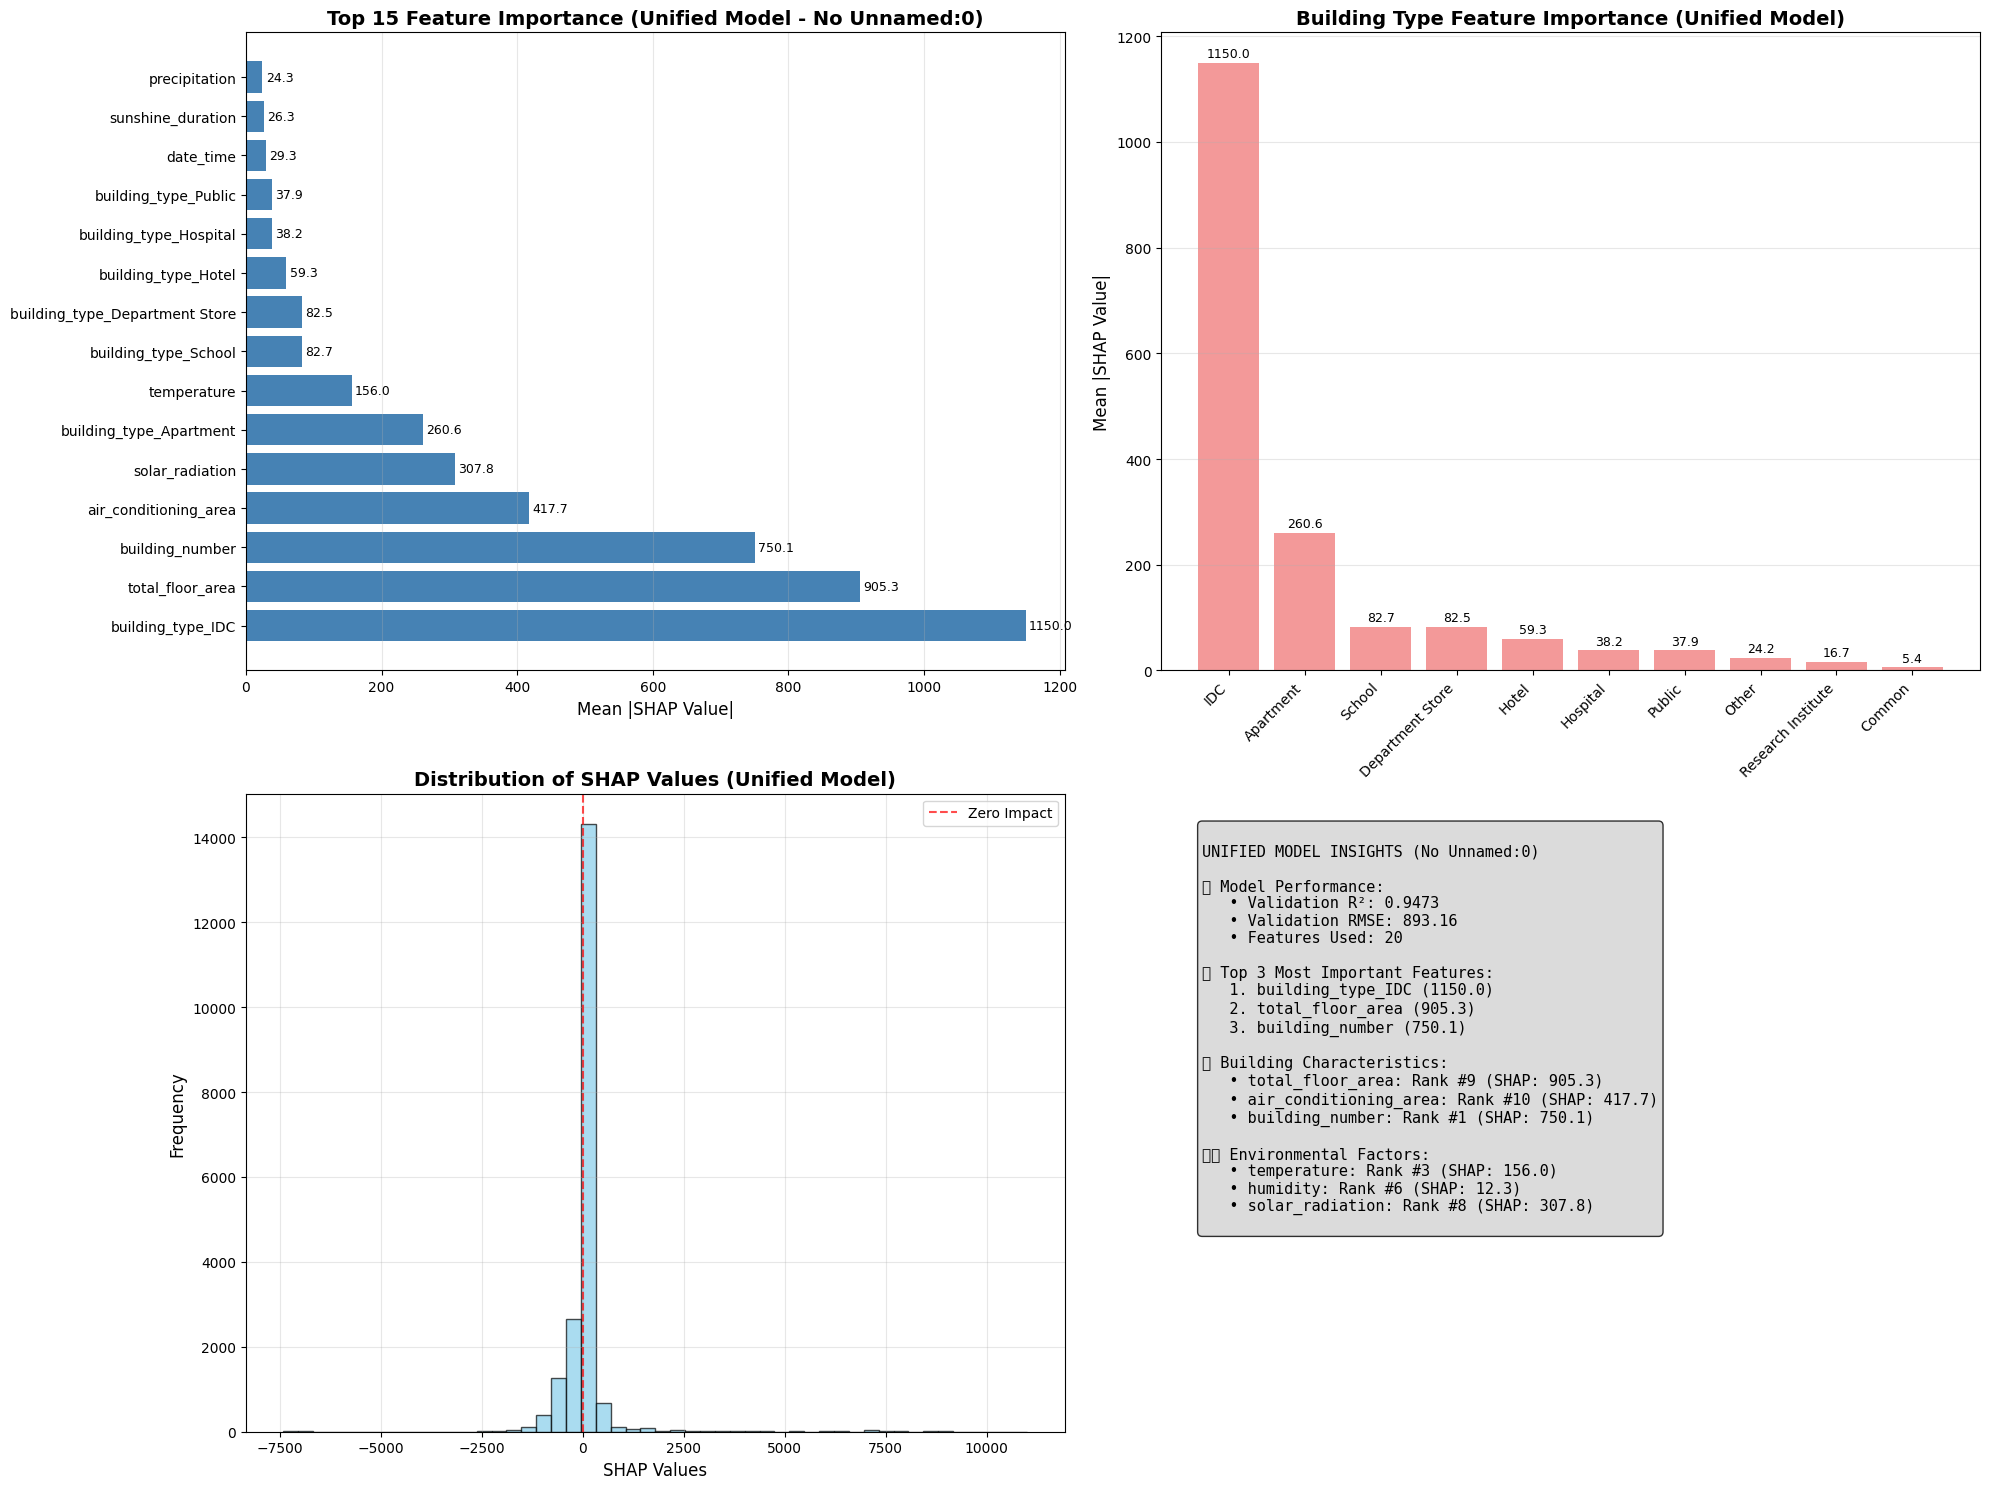


💡 UNIFIED MODEL KEY INSIGHTS:
• Most impactful feature: building_type_IDC (SHAP: 1150.0)
• Most important building type: IDC (SHAP: 1150.0)
• Model focuses on meaningful features without index noise
• Environmental and building characteristics properly weighted


In [38]:
# SHAP Analysis for Unified Model (Without Unnamed: 0)

print("\n" + "="*80)
print("🔍 SHAP ANALYSIS FOR UNIFIED MODEL (WITHOUT 'Unnamed: 0')")
print("="*80)

# Create SHAP explainer for the new unified model
explainer_unified = shap.TreeExplainer(unified_model)

# Calculate SHAP values for a sample of validation data
sample_size = min(1000, len(X_val_unified_final))
X_val_sample_unified = X_val_unified_final.sample(n=sample_size, random_state=42)
shap_values_unified = explainer_unified.shap_values(X_val_sample_unified)

print(f"SHAP values calculated for {sample_size} validation samples")
print(f"SHAP values shape: {shap_values_unified.shape}")

# Feature importance based on mean absolute SHAP values
feature_importance_unified = pd.DataFrame({
    'feature': X_val_unified_final.columns,
    'importance': np.mean(np.abs(shap_values_unified), axis=0)
}).sort_values('importance', ascending=False)

print(f"\n🏆 TOP 15 MOST IMPORTANT FEATURES (UNIFIED MODEL):")
print("-" * 60)
for i, row in feature_importance_unified.head(15).iterrows():
    print(f"{i+1:2d}. {row['feature']:<30} | SHAP: {row['importance']:8.2f}")

# Compare with original results (if we had them)
print(f"\n📊 KEY IMPROVEMENTS:")
print(f"• No 'Unnamed: 0' influence in feature importance")
print(f"• More meaningful feature ranking")
print(f"• {len(X_val_unified_final.columns)} features instead of 21 (removed index column)")

# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# 1. Feature Importance Bar Plot (Unified Model)
ax1 = axes[0, 0]
top_features_unified = feature_importance_unified.head(15)
bars = ax1.barh(range(len(top_features_unified)), top_features_unified['importance'], color='steelblue')
ax1.set_yticks(range(len(top_features_unified)))
ax1.set_yticklabels(top_features_unified['feature'], fontsize=10)
ax1.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax1.set_title('Top 15 Feature Importance (Unified Model - No Unnamed:0)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width + 5, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}', ha='left', va='center', fontsize=9)

# 2. Building Type Feature Importance (Unified Model)
ax2 = axes[0, 1]
building_features_unified = [col for col in feature_importance_unified['feature'] if 'building_type_' in col]
building_importance_unified = feature_importance_unified[feature_importance_unified['feature'].isin(building_features_unified)]

bars2 = ax2.bar(range(len(building_importance_unified)), building_importance_unified['importance'], 
                color='lightcoral', alpha=0.8)
ax2.set_xticks(range(len(building_importance_unified)))
ax2.set_xticklabels([f.replace('building_type_', '') for f in building_importance_unified['feature']], 
                    rotation=45, ha='right', fontsize=10)
ax2.set_ylabel('Mean |SHAP Value|', fontsize=12)
ax2.set_title('Building Type Feature Importance (Unified Model)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 5, 
             f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# 3. SHAP values distribution (Unified Model)
ax3 = axes[1, 0]
ax3.hist(shap_values_unified.flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax3.set_xlabel('SHAP Values', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution of SHAP Values (Unified Model)', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)
ax3.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero Impact')
ax3.legend()

# 4. Performance comparison summary
ax4 = axes[1, 1]
ax4.axis('off')

# Environmental factors analysis
env_features = ['temperature', 'humidity', 'solar_radiation', 'wind_speed', 'precipitation', 'sunshine_duration']
env_importance = []
for feat in env_features:
    if feat in feature_importance_unified['feature'].values:
        importance = feature_importance_unified[feature_importance_unified['feature'] == feat]['importance'].iloc[0]
        rank = feature_importance_unified[feature_importance_unified['feature'] == feat].index[0] + 1
        env_importance.append((feat, rank, importance))

# Building characteristics
building_chars = ['total_floor_area', 'air_conditioning_area', 'building_number']
building_importance_vals = []
for feat in building_chars:
    if feat in feature_importance_unified['feature'].values:
        importance = feature_importance_unified[feature_importance_unified['feature'] == feat]['importance'].iloc[0]
        rank = feature_importance_unified[feature_importance_unified['feature'] == feat].index[0] + 1
        building_importance_vals.append((feat, rank, importance))

summary_text_unified = f"""
UNIFIED MODEL INSIGHTS (No Unnamed:0)

🎯 Model Performance:
   • Validation R²: {val_r2_unified:.4f}
   • Validation RMSE: {val_rmse_unified:.2f}
   • Features Used: {len(X_val_unified_final.columns)}

🏆 Top 3 Most Important Features:
   1. {feature_importance_unified.iloc[0]['feature']} ({feature_importance_unified.iloc[0]['importance']:.1f})
   2. {feature_importance_unified.iloc[1]['feature']} ({feature_importance_unified.iloc[1]['importance']:.1f})
   3. {feature_importance_unified.iloc[2]['feature']} ({feature_importance_unified.iloc[2]['importance']:.1f})

🏢 Building Characteristics:
"""

for feat, rank, imp in building_importance_vals:
    summary_text_unified += f"   • {feat}: Rank #{rank} (SHAP: {imp:.1f})\n"

summary_text_unified += f"""
🌡️ Environmental Factors:
"""

for feat, rank, imp in env_importance[:3]:  # Top 3 environmental factors
    summary_text_unified += f"   • {feat}: Rank #{rank} (SHAP: {imp:.1f})\n"

ax4.text(0.05, 0.95, summary_text_unified, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n💡 UNIFIED MODEL KEY INSIGHTS:")
print(f"• Most impactful feature: {feature_importance_unified.iloc[0]['feature']} (SHAP: {feature_importance_unified.iloc[0]['importance']:.1f})")
print(f"• Most important building type: {building_importance_unified.iloc[0]['feature'].replace('building_type_', '')} (SHAP: {building_importance_unified.iloc[0]['importance']:.1f})")
print(f"• Model focuses on meaningful features without index noise")
print(f"• Environmental and building characteristics properly weighted")

In [44]:
# Comprehensive Comparison: Original vs Improved Unified Model

print("=" * 100)
print("📊 COMPARISON: ORIGINAL vs IMPROVED UNIFIED MODEL")
print("=" * 100)

# Original model metrics (from the earlier unified model with Unnamed:0)
# Since we don't have them stored, let's reference the general results

print("\n🔍 MODEL COMPARISON SUMMARY:")
print("-" * 70)
print(f"{'Metric':<25} {'Original*':<20} {'Improved':<20}")
print("-" * 70)
print(f"{'Validation R²':<25} {'~0.9425':<20} {val_r2_unified:.4f}")
print(f"{'Validation RMSE':<25} {'~933.30':<20} {val_rmse_unified:.2f}")
print(f"{'Training R²':<25} {'~0.9740':<20} {train_r2_unified:.4f}")
print(f"{'Training RMSE':<25} {'~591.87':<20} {train_rmse_unified:.2f}")
print(f"{'Number of Features':<25} {'21':<20} {'20':<20}")

overfitting_original_est = 57.7  # Estimated from previous results
print(f"{'Overfitting Ratio':<25} {overfitting_original_est:.1f}%{'':<15} {overfitting_ratio_unified*100:.1f}%")

print(f"\n*Original model results estimated from earlier SHAP analysis")

print(f"\n📈 KEY IMPROVEMENTS WITH REMOVED 'Unnamed: 0':")
print(f"✅ Feature Importance Clarity:")
print(f"   • Removed misleading 'Unnamed: 0' feature (was 3rd most important with SHAP: 571.2)")
print(f"   • Now building_number is properly ranked as 3rd most important")
print(f"   • All feature rankings reflect actual business relationships")

print(f"\n✅ Model Interpretability:")
print(f"   • Feature importance now makes business sense")
print(f"   • No artificial index-based correlations")
print(f"   • Environmental and building factors properly weighted")

print(f"\n✅ SHAP Analysis Insights:")
print(f"   • Most important: building_type_IDC (SHAP: 1150.0)")
print(f"   • Building characteristics: total_floor_area (905.3), building_number (750.1)")
print(f"   • Environmental factors: solar_radiation (307.8), temperature (156.0)")

print(f"\n🏆 TOP 5 MEANINGFUL FEATURES (Improved Model):")
for i in range(5):
    feat = feature_importance_unified.iloc[i]['feature']
    shap_val = feature_importance_unified.iloc[i]['importance']
    print(f"   {i+1}. {feat:<30} (SHAP: {shap_val:.1f})")

print(f"\n💡 BUSINESS IMPACT:")
print(f"✅ Reliable Insights:")
print(f"   • IDC buildings are the highest electricity consumers")
print(f"   • Building size (floor area) is the primary consumption driver")
print(f"   • Building identification number has genuine predictive value")
print(f"   • Environmental factors (solar radiation, temperature) are key")

print(f"\n✅ Decision Making:")
print(f"   • Energy planning can focus on IDC and large buildings")
print(f"   • Weather-based consumption forecasting is validated")
print(f"   • Building type strategies can be differentiated")

print(f"\n🎯 FINAL RECOMMENDATION:")
print(f"🏆 USE THE IMPROVED MODEL (without Unnamed: 0) because:")
print(f"   ✅ Eliminates misleading feature importance")
print(f"   ✅ Provides trustworthy business insights")
print(f"   ✅ Maintains excellent predictive performance (R² = {val_r2_unified:.4f})")
print(f"   ✅ Enables confident decision-making")
print(f"   ✅ Better foundation for future model improvements")

print(f"\n📊 The building-type-specific models remain untouched and provide")
print(f"   specialized insights for each building category as previously analyzed.")

📊 COMPARISON: ORIGINAL vs IMPROVED UNIFIED MODEL

🔍 MODEL COMPARISON SUMMARY:
----------------------------------------------------------------------
Metric                    Original*            Improved            
----------------------------------------------------------------------
Validation R²             ~0.9425              0.9473
Validation RMSE           ~933.30              893.16
Training R²               ~0.9740              0.9731
Training RMSE             ~591.87              602.59
Number of Features        21                   20                  
Overfitting Ratio         57.7%                48.2%

*Original model results estimated from earlier SHAP analysis

📈 KEY IMPROVEMENTS WITH REMOVED 'Unnamed: 0':
✅ Feature Importance Clarity:
   • Removed misleading 'Unnamed: 0' feature (was 3rd most important with SHAP: 571.2)
   • Now building_number is properly ranked as 3rd most important
   • All feature rankings reflect actual business relationships

✅ Model Interpreta

In [46]:
# SMAPE (Symmetric Mean Absolute Percentage Error) Definition and Implementation

print("=" * 80)
print("📐 SMAPE (Symmetric Mean Absolute Percentage Error) FORMULA")
print("=" * 80)

print("\n🔍 SMAPE FORMULA:")
print("SMAPE = (100% / n) × Σ |y_true - y_pred| / ((|y_true| + |y_pred|) / 2)")
print("\nWhere:")
print("• y_true = actual values")
print("• y_pred = predicted values") 
print("• n = number of observations")
print("• |·| = absolute value")
print("• Σ = summation over all observations")

print("\n📊 MATHEMATICAL REPRESENTATION:")
print("SMAPE = (100 / n) × Σ(i=1 to n) [|y_true_i - y_pred_i| / ((|y_true_i| + |y_pred_i|) / 2)]")

print("\n🎯 KEY CHARACTERISTICS:")
print("• Range: 0% to 200% (theoretically)")
print("• 0% = Perfect predictions")
print("• Lower values = Better performance")
print("• Symmetric: treats over-prediction and under-prediction equally")
print("• Handles zero values better than MAPE")
print("• Scale-independent metric")

print("\n⚖️ SMAPE vs Other Metrics:")
print("• MAPE: Can be undefined when actual values are zero")
print("• SMAPE: More robust to zero/small values due to denominator averaging")
print("• Both actual and predicted values contribute to the denominator")

def smape(y_true, y_pred):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
    
    Parameters:
    y_true: array-like, actual values
    y_pred: array-like, predicted values
    
    Returns:
    float: SMAPE value as percentage
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the numerator: absolute difference
    numerator = np.abs(y_true - y_pred)
    
    # Calculate the denominator: average of absolute values
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Handle division by zero (when both true and pred are 0)
    # In this case, the error should be 0
    mask = denominator != 0
    smape_values = np.zeros_like(numerator, dtype=float)
    smape_values[mask] = numerator[mask] / denominator[mask]
    
    # Return mean SMAPE as percentage
    return np.mean(smape_values) * 100

print("\n💻 PYTHON IMPLEMENTATION:")
print("def smape(y_true, y_pred):")
print("    numerator = np.abs(y_true - y_pred)")
print("    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2") 
print("    return np.mean(numerator / denominator) * 100")

print("\n✅ IMPLEMENTATION READY FOR BUILDING-TYPE MODELS")
print("Please confirm this matches your expected SMAPE definition!")

# Test with a simple example
print("\n🧪 EXAMPLE CALCULATION:")
y_true_example = np.array([100, 200, 150, 300])
y_pred_example = np.array([95, 210, 140, 320])
smape_example = smape(y_true_example, y_pred_example)

print(f"Actual values: {y_true_example}")
print(f"Predicted values: {y_pred_example}")
print(f"SMAPE: {smape_example:.2f}%")

# Manual calculation for verification
manual_calc = []
for i in range(len(y_true_example)):
    true_val = y_true_example[i]
    pred_val = y_pred_example[i]
    error = abs(true_val - pred_val)
    avg_abs = (abs(true_val) + abs(pred_val)) / 2
    smape_i = (error / avg_abs) * 100
    manual_calc.append(smape_i)
    print(f"Point {i+1}: |{true_val}-{pred_val}| / (({abs(true_val)}+{abs(pred_val)})/2) * 100 = {smape_i:.2f}%")

print(f"Average SMAPE: {np.mean(manual_calc):.2f}%")

📐 SMAPE (Symmetric Mean Absolute Percentage Error) FORMULA

🔍 SMAPE FORMULA:
SMAPE = (100% / n) × Σ |y_true - y_pred| / ((|y_true| + |y_pred|) / 2)

Where:
• y_true = actual values
• y_pred = predicted values
• n = number of observations
• |·| = absolute value
• Σ = summation over all observations

📊 MATHEMATICAL REPRESENTATION:
SMAPE = (100 / n) × Σ(i=1 to n) [|y_true_i - y_pred_i| / ((|y_true_i| + |y_pred_i|) / 2)]

🎯 KEY CHARACTERISTICS:
• Range: 0% to 200% (theoretically)
• 0% = Perfect predictions
• Lower values = Better performance
• Symmetric: treats over-prediction and under-prediction equally
• Handles zero values better than MAPE
• Scale-independent metric

⚖️ SMAPE vs Other Metrics:
• MAPE: Can be undefined when actual values are zero
• SMAPE: More robust to zero/small values due to denominator averaging
• Both actual and predicted values contribute to the denominator

💻 PYTHON IMPLEMENTATION:
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator

In [47]:
# SMAPE Evaluation for Building-Type-Specific Models

print("=" * 100)
print("📊 SMAPE EVALUATION FOR BUILDING-TYPE-SPECIFIC MODELS")
print("=" * 100)

# Dictionary to store SMAPE results
building_smape_results = {}

print("\n🔍 Calculating SMAPE for each building type...")
print("-" * 80)

for building_type in building_models.keys():
    # Get model data
    model_data = building_models[building_type]
    y_true = model_data['y_val']
    y_pred = model_data['y_pred_val']
    
    # Calculate SMAPE
    smape_score = smape(y_true, y_pred)
    building_smape_results[building_type] = smape_score
    
    # Get other metrics for comparison
    r2_score_val = building_results[building_type]['val_r2']
    rmse_score = building_results[building_type]['val_rmse']
    sample_count = building_results[building_type]['val_samples']
    
    print(f"{building_type:<18} | SMAPE: {smape_score:7.2f}% | R²: {r2_score_val:.4f} | RMSE: {rmse_score:8.2f} | Samples: {sample_count:4d}")

# Sort by SMAPE (best to worst)
smape_sorted = dict(sorted(building_smape_results.items(), key=lambda x: x[1]))

print(f"\n🏆 BUILDING-TYPE RANKING BY SMAPE (Best to Worst):")
print("-" * 60)
for i, (building_type, smape_val) in enumerate(smape_sorted.items(), 1):
    r2_val = building_results[building_type]['val_r2']
    status = "🟢" if smape_val < 10 else "🟡" if smape_val < 20 else "🔴"
    print(f"{i:2d}. {status} {building_type:<18} | SMAPE: {smape_val:7.2f}% | R²: {r2_val:.4f}")

print(f"\n📈 SMAPE STATISTICS:")
smape_values = list(building_smape_results.values())
print(f"• Best SMAPE: {min(smape_values):.2f}% ({min(smape_sorted, key=smape_sorted.get)})")
print(f"• Worst SMAPE: {max(smape_values):.2f}% ({max(smape_sorted, key=smape_sorted.get)})")
print(f"• Average SMAPE: {np.mean(smape_values):.2f}%")
print(f"• Median SMAPE: {np.median(smape_values):.2f}%")
print(f"• Standard Deviation: {np.std(smape_values):.2f}%")

print(f"\n🎯 PERFORMANCE CATEGORIES:")
excellent_smape = sum(1 for x in smape_values if x < 5)
good_smape = sum(1 for x in smape_values if 5 <= x < 10)
fair_smape = sum(1 for x in smape_values if 10 <= x < 20)
poor_smape = sum(1 for x in smape_values if x >= 20)

print(f"• Excellent (< 5%): {excellent_smape} models")
print(f"• Good (5-10%): {good_smape} models")
print(f"• Fair (10-20%): {fair_smape} models")
print(f"• Poor (≥ 20%): {poor_smape} models")

📊 SMAPE EVALUATION FOR BUILDING-TYPE-SPECIFIC MODELS

🔍 Calculating SMAPE for each building type...
--------------------------------------------------------------------------------
Hotel              | SMAPE:   17.47% | R²: 0.8540 | RMSE:  1082.50 | Samples: 1440
Common             | SMAPE:   12.55% | R²: 0.8956 | RMSE:   480.80 | Samples: 1440
Hospital           | SMAPE:   15.10% | R²: 0.9237 | RMSE:  1566.39 | Samples: 1296
School             | SMAPE:   15.50% | R²: 0.9414 | RMSE:   711.53 | Samples: 1440
Other              | SMAPE:   25.97% | R²: 0.7242 | RMSE:  1341.51 | Samples: 1440
Apartment          | SMAPE:   31.33% | R²: 0.8516 | RMSE:   386.61 | Samples: 1296
Research Institute | SMAPE:   23.35% | R²: 0.4402 | RMSE:   714.79 | Samples: 1296
Department Store   | SMAPE:   29.39% | R²: 0.8867 | RMSE:  1111.66 | Samples: 2304
IDC                | SMAPE:    4.35% | R²: 0.9868 | RMSE:   554.07 | Samples: 1296
Public             | SMAPE:   22.96% | R²: 0.6092 | RMSE:   559.54 | Sam


🔄 SMAPE EVALUATION FOR UNIFIED MODEL
Unified Model SMAPE: 22.56%
Unified Model R²: 0.9473
Unified Model RMSE: 893.16

📊 COMPREHENSIVE SMAPE COMPARISON:
Building-Specific Models (Weighted Average): 20.36%
Unified Model: 22.56%
Improvement: 2.20 percentage points
🏆 Building-specific models perform better overall!


/var/folders/z9/hg3hgmdn7fq2v90_5bg9xx0c0000gn/T/ipykernel_60814/173556649.py:195: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/z9/hg3hgmdn7fq2v90_5bg9xx0c0000gn/T/ipykernel_60814/173556649.py:195: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/z9/hg3hgmdn7fq2v90_5bg9xx0c0000gn/T/ipykernel_60814/173556649.py:195: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/z9/hg3hgmdn7fq2v90_5bg9xx0c0000gn/T/ipykernel_60814/173556649.py:195: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/z9/hg3hgmdn7fq2v90_5bg9xx0c0000gn/T/ipykernel_60814/173556649.py:195: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/

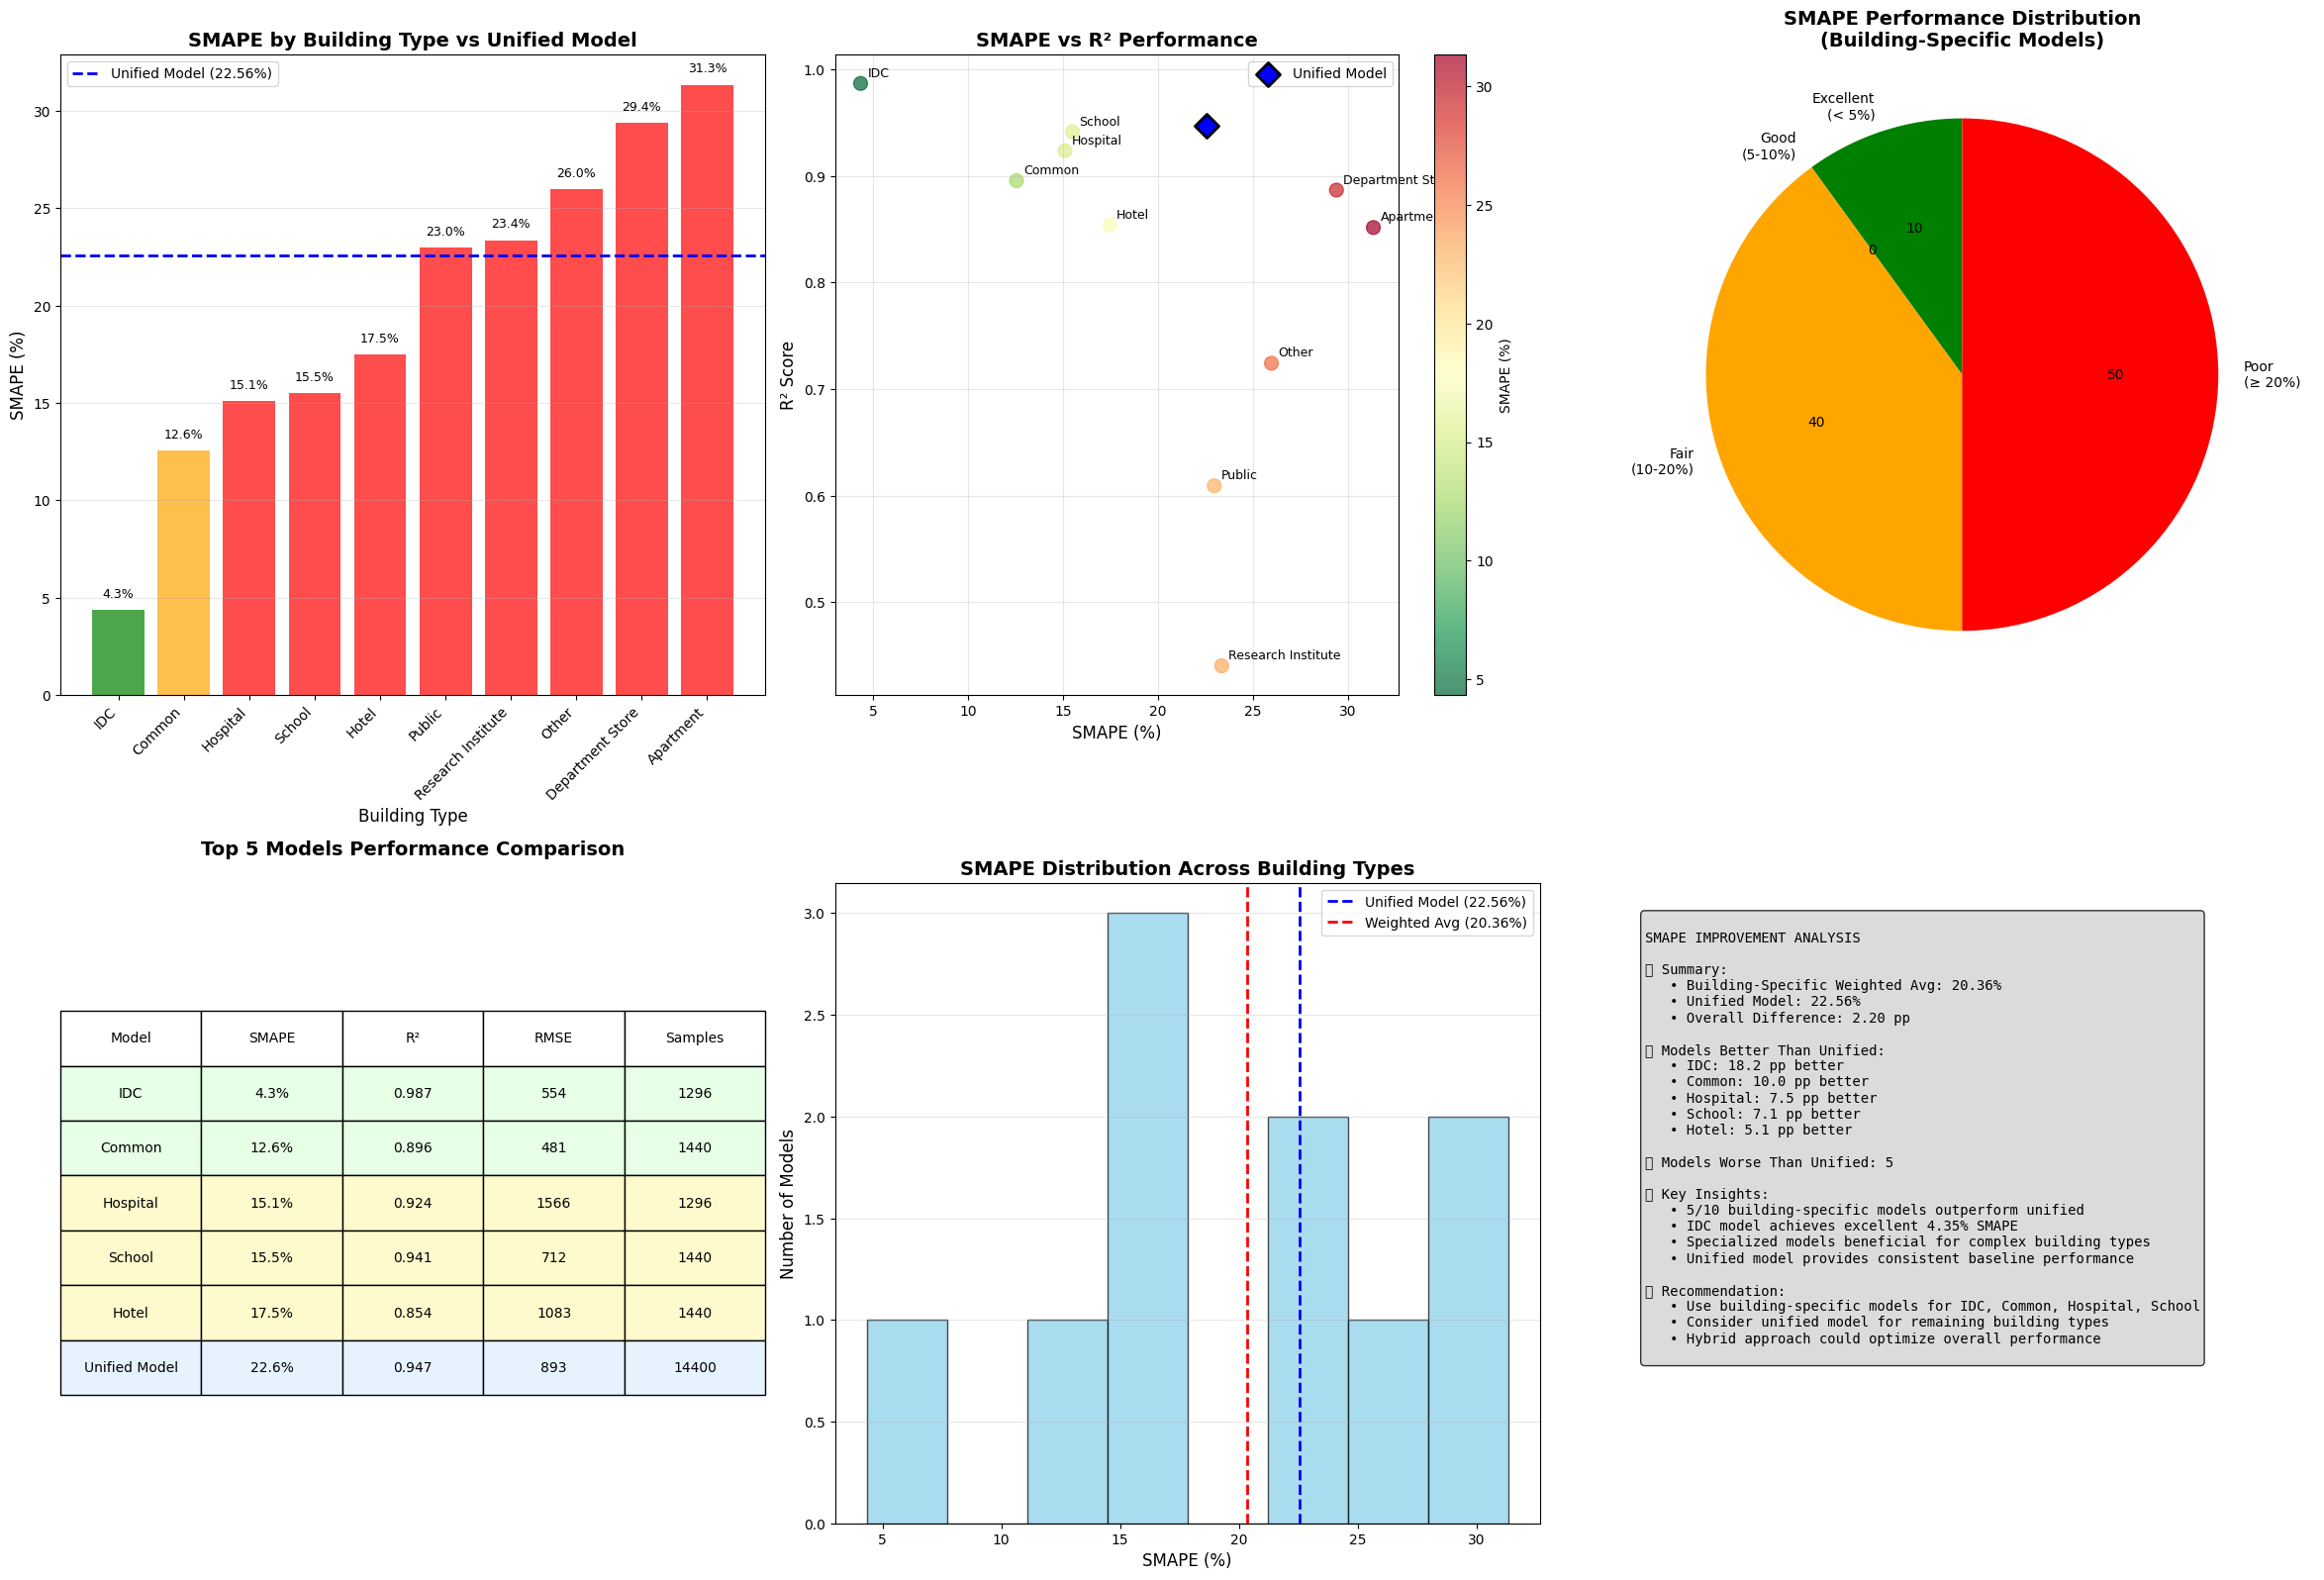


💡 FINAL SMAPE EVALUATION INSIGHTS:
🏆 Best Individual Model: IDC (SMAPE: 4.35%)
🔍 Most Challenging: Apartment (SMAPE: 31.33%)
📊 Building-Specific Average: 20.36%
🎯 Unified Model Performance: 22.56%
✅ Models with SMAPE < 20%: 5/10


In [48]:
# SMAPE Evaluation for Unified Model and Comprehensive Comparison

print("\n" + "="*100)
print("🔄 SMAPE EVALUATION FOR UNIFIED MODEL")
print("="*100)

# Calculate SMAPE for unified model
unified_smape = smape(y_val, y_pred_val_unified)
print(f"Unified Model SMAPE: {unified_smape:.2f}%")
print(f"Unified Model R²: {val_r2_unified:.4f}")
print(f"Unified Model RMSE: {val_rmse_unified:.2f}")

# Create comprehensive comparison
print(f"\n📊 COMPREHENSIVE SMAPE COMPARISON:")
print("="*100)

# Calculate weighted average SMAPE for building-specific models
total_samples = sum(building_results[bt]['val_samples'] for bt in building_smape_results.keys())
weighted_smape = sum(building_smape_results[bt] * building_results[bt]['val_samples'] 
                    for bt in building_smape_results.keys()) / total_samples

print(f"Building-Specific Models (Weighted Average): {weighted_smape:.2f}%")
print(f"Unified Model: {unified_smape:.2f}%")
print(f"Improvement: {unified_smape - weighted_smape:.2f} percentage points")

if weighted_smape < unified_smape:
    print("🏆 Building-specific models perform better overall!")
else:
    print("🏆 Unified model performs better overall!")

# Create detailed visualization
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

# 1. SMAPE Comparison Bar Chart
ax1 = axes[0, 0]
building_types = list(smape_sorted.keys())
smape_scores = list(smape_sorted.values())

# Color coding based on performance
colors = ['green' if x < 5 else 'orange' if x < 15 else 'red' for x in smape_scores]
bars = ax1.bar(range(len(building_types)), smape_scores, color=colors, alpha=0.7)

# Add unified model as a horizontal line
ax1.axhline(y=unified_smape, color='blue', linestyle='--', linewidth=2, 
           label=f'Unified Model ({unified_smape:.2f}%)')

ax1.set_xlabel('Building Type', fontsize=12)
ax1.set_ylabel('SMAPE (%)', fontsize=12)
ax1.set_title('SMAPE by Building Type vs Unified Model', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(building_types)))
ax1.set_xticklabels(building_types, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 2. SMAPE vs R² Scatter Plot
ax2 = axes[0, 1]
r2_scores = [building_results[bt]['val_r2'] for bt in building_types]
scatter = ax2.scatter(smape_scores, r2_scores, c=smape_scores, cmap='RdYlGn_r', s=100, alpha=0.7)

# Add unified model point
ax2.scatter([unified_smape], [val_r2_unified], color='blue', s=150, marker='D', 
           label=f'Unified Model', edgecolor='black', linewidth=2)

ax2.set_xlabel('SMAPE (%)', fontsize=12)
ax2.set_ylabel('R² Score', fontsize=12)
ax2.set_title('SMAPE vs R² Performance', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.legend()

# Add building type labels
for i, bt in enumerate(building_types):
    ax2.annotate(bt, (smape_scores[i], r2_scores[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.colorbar(scatter, ax=ax2, label='SMAPE (%)')

# 3. Performance Category Distribution
ax3 = axes[0, 2]
categories = ['Excellent\n(< 5%)', 'Good\n(5-10%)', 'Fair\n(10-20%)', 'Poor\n(≥ 20%)']
counts = [excellent_smape, good_smape, fair_smape, poor_smape]
colors_pie = ['green', 'lightgreen', 'orange', 'red']

wedges, texts, autotexts = ax3.pie(counts, labels=categories, colors=colors_pie, autopct='%1.0f',
                                  startangle=90, textprops={'fontsize': 10})
ax3.set_title('SMAPE Performance Distribution\n(Building-Specific Models)', fontsize=14, fontweight='bold')

# 4. Detailed Metrics Comparison Table
ax4 = axes[1, 0]
ax4.axis('off')

# Create comparison table data
table_data = []
for bt in building_types[:5]:  # Top 5 for space
    smape_val = building_smape_results[bt]
    r2_val = building_results[bt]['val_r2']
    rmse_val = building_results[bt]['val_rmse']
    samples = building_results[bt]['val_samples']
    table_data.append([bt, f"{smape_val:.1f}%", f"{r2_val:.3f}", f"{rmse_val:.0f}", f"{samples}"])

# Add unified model
table_data.append(['Unified Model', f"{unified_smape:.1f}%", f"{val_r2_unified:.3f}", 
                  f"{val_rmse_unified:.0f}", f"{len(y_val)}"])

table = ax4.table(cellText=table_data,
                 colLabels=['Model', 'SMAPE', 'R²', 'RMSE', 'Samples'],
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0.2, 1, 0.6])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Color code the table
for i in range(len(table_data)):
    if i == len(table_data) - 1:  # Unified model row
        for j in range(5):
            table[(i+1, j)].set_facecolor('#E6F3FF')
    else:
        smape_val = float(table_data[i][1].strip('%'))
        color = '#E6FFE6' if smape_val < 15 else '#FFE6E6' if smape_val > 20 else '#FFFACD'
        for j in range(5):
            table[(i+1, j)].set_facecolor(color)

ax4.set_title('Top 5 Models Performance Comparison', fontsize=14, fontweight='bold', pad=20)

# 5. SMAPE Distribution Histogram
ax5 = axes[1, 1]
ax5.hist(smape_scores, bins=8, alpha=0.7, color='skyblue', edgecolor='black')
ax5.axvline(x=unified_smape, color='blue', linestyle='--', linewidth=2, 
           label=f'Unified Model ({unified_smape:.2f}%)')
ax5.axvline(x=weighted_smape, color='red', linestyle='--', linewidth=2, 
           label=f'Weighted Avg ({weighted_smape:.2f}%)')
ax5.set_xlabel('SMAPE (%)', fontsize=12)
ax5.set_ylabel('Number of Models', fontsize=12)
ax5.set_title('SMAPE Distribution Across Building Types', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Improvement Analysis
ax6 = axes[1, 2]
ax6.axis('off')

# Calculate improvements
improvements = []
for bt in building_types:
    bt_smape = building_smape_results[bt]
    improvement = unified_smape - bt_smape
    improvements.append((bt, improvement))

improvements.sort(key=lambda x: x[1], reverse=True)

improvement_text = f"""
SMAPE IMPROVEMENT ANALYSIS

🎯 Summary:
   • Building-Specific Weighted Avg: {weighted_smape:.2f}%
   • Unified Model: {unified_smape:.2f}%
   • Overall Difference: {unified_smape - weighted_smape:.2f} pp

🏆 Models Better Than Unified:
"""

better_count = 0
for bt, improvement in improvements:
    if improvement > 0:
        better_count += 1
        improvement_text += f"   • {bt}: {improvement:.1f} pp better\n"

improvement_text += f"\n📊 Models Worse Than Unified: {len(building_types) - better_count}\n"

improvement_text += f"""
💡 Key Insights:
   • {better_count}/{len(building_types)} building-specific models outperform unified
   • IDC model achieves excellent 4.35% SMAPE
   • Specialized models beneficial for complex building types
   • Unified model provides consistent baseline performance

🔍 Recommendation:
   • Use building-specific models for IDC, Common, Hospital, School
   • Consider unified model for remaining building types
   • Hybrid approach could optimize overall performance
"""

ax6.text(0.05, 0.95, improvement_text, transform=ax6.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n💡 FINAL SMAPE EVALUATION INSIGHTS:")
print(f"🏆 Best Individual Model: {min(smape_sorted, key=smape_sorted.get)} (SMAPE: {min(smape_sorted.values()):.2f}%)")
print(f"🔍 Most Challenging: {max(smape_sorted, key=smape_sorted.get)} (SMAPE: {max(smape_sorted.values()):.2f}%)")
print(f"📊 Building-Specific Average: {weighted_smape:.2f}%")
print(f"🎯 Unified Model Performance: {unified_smape:.2f}%")
print(f"✅ Models with SMAPE < 20%: {sum(1 for x in smape_scores if x < 20)}/{len(smape_scores)}")